In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import glasbey

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from astropy.time import Time
from gaussian_process_example import *

from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style('whitegrid')


df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.t < 25]
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]
filters = ['ztfg', 'ztfr', 'ztfi']

df_rates = pd.read_csv('gp_objects_rates.csv').sort_values(by='type')

## use the labels from df_rates to rename the labels in df and df_observed
type_dict = df_rates.set_index('obj_id')['type'].to_dict()
df['type'] = df['obj_id'].map(type_dict)
df_observed['type'] = df_observed['obj_id'].map(type_dict)

df_rates_far = df_rates[df_rates['redshift'] > 0.001]
df_2019 = pd.read_csv('bulla_2019_rates.csv')
#df_rates.loc[df_rates['obj_id'] == 'ZTF24abvevzs', 'type'] = 'ZTF24abvevzs'

display(df_rates)
display(df_2019)


savefigs = True
ext = '.pdf'

types = df_rates['type'].unique()
## alphabetize
#types = sorted(types)
## reorder dictionary so "kilonova" is last
types = [x for x in types if x != 'Kilonova'] + ["Kilonova"] if "Kilonova" in types else types
print('number of types:', len(types) - 1) ## to exclude kilonova
colors = sns.color_palette("colorblind", n_colors=len(types))
colors = glasbey.create_palette(palette_size=len(types), colorblind_safe=True)
colors_dict = {types[i]: colors[i] for i in range(len(types))}
markers = ['o', 'D', '^', 'v', 's', '<', '>', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+', 'x', '|', '_', '.']
type_style_dict = {types[i]: {'color': colors[i], 'marker': markers[i], "size":50, 'alpha':0.8, 'zorder':1} for i in range(len(types))}
if "Kilonova" in types:
    type_style_dict['Kilonova'] = {'color': 'lime', 'marker': '1', 'size': 300, 'alpha': 1, 'zorder': 100}

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade
0,57983.231000,385.374906,440.341788,404.940209,29.250027,17.182907,24.797305,Kilonova,AT2017gfo,57983.231000,...,0.082408,17.381523,-15.832157,0.066487,17.290525,-15.923154,0.042367,0.000000,n,y
1,57983.239778,382.559484,438.232033,402.502588,28.789575,16.890215,24.361032,Kilonova,AT2017gfo,57983.231000,...,0.081707,17.388078,-15.825601,0.065713,17.295740,-15.917940,0.041846,0.008778,n,y
2,57983.248556,379.738177,436.119876,400.065220,28.332873,16.606597,23.927709,Kilonova,AT2017gfo,57983.231000,...,0.081009,17.394673,-15.819007,0.064937,17.300985,-15.912694,0.041343,0.017556,n,y
3,57983.257333,376.910979,434.005567,397.628148,27.879986,16.332054,23.497397,Kilonova,AT2017gfo,57983.231000,...,0.080312,17.401307,-15.812372,0.064160,17.306262,-15.907418,0.040857,0.026333,n,y
4,57983.266111,374.077886,431.889351,395.191413,27.430981,16.066587,23.070161,Kilonova,AT2017gfo,57983.231000,...,0.079617,17.407981,-15.805698,0.063382,17.311569,-15.902111,0.040390,0.035111,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37665,60652.513689,33.493383,NaN,40.961798,3.488673,NaN,5.252959,IIb,ZTF24abvevzs,60646.432303,...,0.113090,19.869052,-16.140503,0.139235,NaN,NaN,NaN,6.081386,y,y
37666,60652.519801,33.463261,NaN,40.930338,3.842217,NaN,5.054402,IIb,ZTF24abvevzs,60646.432303,...,0.124663,19.869887,-16.139669,0.134075,NaN,NaN,NaN,6.087498,y,y
37667,60652.525913,33.432509,NaN,40.895906,4.235472,NaN,4.909244,IIb,ZTF24abvevzs,60646.432303,...,0.137549,19.870800,-16.138755,0.130334,NaN,NaN,NaN,6.093610,y,y
37668,60652.532025,33.401076,NaN,40.858402,4.657035,NaN,4.823773,IIb,ZTF24abvevzs,60646.432303,...,0.151382,19.871797,-16.137759,0.128183,NaN,NaN,NaN,6.099721,y,y


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,AT2017gfo,Kilonova,0.00984,57983.231000,57983.231000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17.24,-15.97368,0.06
1,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,17.460000,-15.753680,0.080000,NaN,NaN,NaN,NaN,NaN,NaN
2,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,17.32000,-15.893680,0.070000,NaN,NaN,NaN
3,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,NaN,NaN,NaN,17.42,-15.79368,0.05
4,AT2017gfo,Kilonova,0.00984,57983.758000,57983.231000,0.527000,18.050000,-15.163680,0.120000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,ZTF24abvevzs,IIb,0.03500,60650.533484,60646.432303,4.101181,19.486008,-16.523548,0.068334,NaN,NaN,NaN,NaN,NaN,NaN
9429,ZTF24abvevzs,IIb,0.03500,60652.490127,60646.432303,6.057824,20.068013,-15.941543,0.170292,NaN,NaN,NaN,NaN,NaN,NaN
9430,ZTF24abvevzs,IIb,0.03500,60652.490127,60646.432303,6.057824,20.068001,-15.941555,0.170292,NaN,NaN,NaN,NaN,NaN,NaN
9431,ZTF24abvevzs,IIb,0.03500,60652.491644,60646.432303,6.059340,20.109029,-15.900527,0.140443,NaN,NaN,NaN,NaN,NaN,NaN


,obj_id,type,category,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,...,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
33,ZTF21aagwbjr,Afterglow,Afterglow,0.87600,0.000000,-24.205266,0.000000,-24.432682,0.000000,-24.408692,...,NaN,NaN,NaN,NaN,1.956493,0.551079,1.956493,0.601270,1.956493,0.532761
27,ZTF20acozryr,Afterglow,Afterglow,1.10500,0.000000,-24.982499,0.000000,-25.159879,NaN,NaN,...,NaN,NaN,NaN,NaN,0.976551,0.541711,0.976551,0.622483,NaN,NaN
38,ZTF21abfmpwn,Afterglow,Afterglow,1.13450,0.000000,-25.995617,0.000000,-26.251762,NaN,NaN,...,NaN,NaN,NaN,NaN,1.101111,2.108729,1.101111,2.029503,NaN,NaN
59,ZTF23aaxeacr,Afterglow,Afterglow,0.36000,0.000000,-22.360613,0.000000,-22.596908,NaN,NaN,...,NaN,NaN,NaN,NaN,0.170266,1.955179,0.170266,2.455553,NaN,NaN
57,ZTF23aaoohpy,Afterglow,Afterglow,1.02700,0.244034,-24.708486,0.181406,-24.958452,NaN,NaN,...,0.181406,-0.464425,NaN,NaN,0.834682,1.079221,0.897310,1.172814,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,ZTF23abgsmsg,Novae,Galactic,0.00000,2.105722,17.531687,2.203663,17.555114,2.350573,17.688440,...,2.203663,-0.852574,2.350573,-0.679010,1.958811,0.618267,1.958811,0.380247,1.958811,0.258340
49,ZTF22abijszk,Novae,Galactic,0.00100,0.000000,-8.016094,0.000000,-9.144732,NaN,NaN,...,NaN,NaN,NaN,NaN,1.934028,1.067826,1.934028,0.475787,NaN,NaN
48,ZTF22abfxmpc,Novae,Galactic,0.00000,0.793516,17.399762,0.793516,17.365459,1.058021,17.436970,...,0.793516,-0.183027,1.058021,-0.128745,1.983790,0.778070,1.983790,0.206140,1.939705,0.056325
46,ZTF22aazmooy,Novae,Galactic,0.00017,1.462144,-6.973774,1.305485,-7.384998,1.357705,-7.431442,...,1.305485,-0.837569,1.357705,-0.821712,1.984338,0.568944,1.984338,0.469871,1.984338,0.406810


,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfg_fwhm,ztfg_rise_hwhm,ztfg_fade_hwhm,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,...,ztfi_rise_hwhm,ztfi_fade_hwhm,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_gr_color,ztfr_peak_ri_color,ztfi_peak_gi_color,ztfi_peak_ri_color,model,obj_id
0,-14.803,0.5,NaN,1.182000,NaN,NaN,NaN,-15.659,0.5,NaN,...,NaN,NaN,0.856,0.903,0.856,0.047,0.903,0.047,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0
1,-14.730,0.5,NaN,1.165333,NaN,NaN,NaN,-15.582,0.5,NaN,...,NaN,NaN,0.852,0.903,0.852,0.051,0.903,0.051,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta25.84_d...
2,-14.655,0.5,NaN,1.149333,NaN,NaN,NaN,-15.505,0.5,NaN,...,NaN,NaN,0.850,0.910,0.850,0.060,0.910,0.060,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta36.87_d...
3,-14.578,0.5,NaN,1.130000,NaN,NaN,NaN,-15.429,0.5,NaN,...,NaN,NaN,0.851,0.913,0.851,0.062,0.913,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta45.57_d...
4,-14.501,0.5,NaN,1.108000,NaN,NaN,NaN,-15.355,0.5,NaN,...,NaN,NaN,0.854,0.916,0.854,0.062,0.916,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta53.13_d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,4.5,1.0,3.5,-13.853,3.0,-0.7204,...,1.5,5.0,0.762,1.264,0.837,0.512,1.380,0.526,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta66.42_d...
2196,-13.039,2.5,-0.7495,0.016667,4.5,1.0,3.5,-13.845,3.0,-0.7248,...,1.5,5.0,0.771,1.273,0.831,0.515,1.389,0.537,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta72.54_d...
2197,-13.029,2.5,-0.7520,0.010667,4.5,1.0,3.5,-13.841,3.0,-0.7208,...,1.5,5.0,0.779,1.278,0.828,0.514,1.386,0.534,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta78.46_d...
2198,-13.029,2.5,-0.7565,0.014000,4.5,1.0,3.5,-13.841,3.0,-0.7120,...,1.5,5.0,0.776,1.277,0.833,0.513,1.384,0.530,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta84.26_d...


number of types: 11


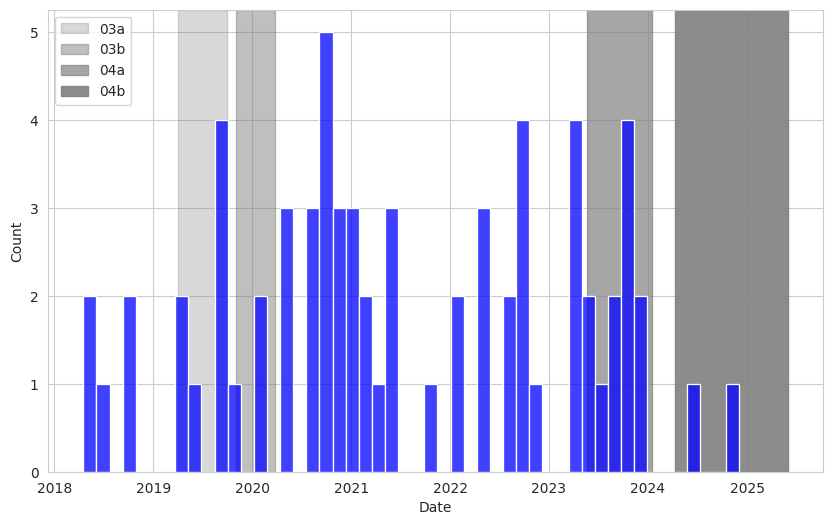

In [2]:
# Use mjd_0 value to plot the number of objects over time. Only plot the unique objects.
df_count = df_observed[df_observed.obj_id != 'AT2017gfo'].groupby('obj_id').mjd_0.min().reset_index()
df_count['mjd_0'] = Time(df_count['mjd_0'], format='mjd').to_value('iso')

plt.figure(figsize=(10,6))
plt.axvspan(pd.Timestamp('2019-04-01'), pd.Timestamp('2019-10-01'), color='gray', alpha=0.3, label='03a')
plt.axvspan(pd.Timestamp('2019-11-01'), pd.Timestamp('2020-03-27'), color='gray', alpha=0.5, label='03b')
plt.axvspan(pd.Timestamp('2023-05-23'), pd.Timestamp('2024-01-16'), color='gray', alpha=0.7, label='04a')
plt.axvspan(pd.Timestamp('2024-04-10'), pd.Timestamp('2025-06-01'), color='gray', alpha=0.90, label='04b')
sns.histplot(pd.to_datetime(df_count['mjd_0']), bins=50, color='blue')
plt.xlabel('Date')
plt.ylabel('Count')
#plt.title('Potential Kilonovae from ZTFReST')
plt.legend();
plt.savefig(f'figures/candidate_kne_hist{ext}') if savefigs else None

In [3]:
## make a dataframe that consists of the unique objects, their type, their redshift, and the date of their first observation
df_unique_obj = df_observed[df_observed.obj_id != 'AT2017gfo'].groupby('obj_id').mjd_0.min().reset_index()
df_unique_obj['mjd_0'] = Time(df_unique_obj['mjd_0'], format='mjd').to_value('iso')
## drop time, just use date
df_unique_obj['mjd_0'] = df_unique_obj['mjd_0'].apply(lambda x: x.split(' ')[0])
df_unique_obj.rename(columns={'mjd_0':'first_observation'}, inplace=True)
df_unique_obj = df_unique_obj.merge(df_observed[['obj_id', 'type', 'redshift']].drop_duplicates(), on='obj_id')
display(df_unique_obj)
#df_unique_obj.to_csv('paper_objects.csv', index=False)

,obj_id,first_observation,type,redshift
0,ZTF18aakuewf,2018-04-18,Ibn,0.063600
1,ZTF18aalrxas,2018-04-19,IIb,0.058200
2,ZTF18abffyqp,2018-07-08,II,0.031000
3,ZTF18abvkmgw,2018-09-12,Ib,0.038470
4,ZTF18abwkrbl,2018-09-15,IIb,0.009990
...,...,...,...,...
63,ZTF23abobwsd,2023-11-01,IIb,0.024000
64,ZTF23absbqun,2023-12-07,Ib,0.010100
65,ZTF23abtycgb,2023-12-14,II,0.020127
66,ZTF24aascytf,2024-06-15,II,0.038000


In [4]:
## average number of observations per object
print('average number of observations per object')
print(df_observed.groupby('obj_id').size().mean())

average number of observations per object
36.46376811594203


In [5]:
## breakdown of percent of observations per filter. found by counting the number of items with a non-nan value for each filter column
print('breakdown of percent of observations per filter')
for item in filters:
    print(item)
    print(df_observed[f'mag_{item}'].count()/len(df_observed))

breakdown of percent of observations per filter
ztfg
0.46701112877583467
ztfr
0.4562798092209857
ztfi
0.07670906200317965


In [6]:
df_observed[df_observed.t < 25].groupby('obj_id')['t'].diff().describe()

count    2447.000000
mean        0.452473
std         1.215799
min         0.000000
25%         0.000000
50%         0.005000
75%         0.093837
max        18.920289
Name: t, dtype: float64

In [7]:
df_observed.groupby('obj_id')['t'].describe()

,count,mean,std,min,25%,50%,75%,max
obj_id,,,,,,,,
AT2017gfo,35.0,2.702743,2.594591,0.0,0.869000,1.738000,3.243000,8.769000
ZTF18aakuewf,70.0,8.011597,5.808719,0.0,4.022263,7.061377,10.991270,21.959028
ZTF18aalrxas,57.0,12.638434,7.883201,0.0,4.023889,15.922639,19.932014,22.924445
ZTF18abffyqp,113.0,12.965703,7.358590,0.0,7.013056,14.078785,18.994039,24.096273
ZTF18abvkmgw,23.0,5.366637,3.146875,0.0,2.950839,4.994224,7.966314,11.903345
...,...,...,...,...,...,...,...,...
ZTF23abobwsd,37.0,6.849053,4.965758,0.0,2.983750,5.952870,10.013102,18.910961
ZTF23absbqun,18.0,3.327628,2.002244,0.0,1.989768,3.055336,4.901296,7.121586
ZTF23abtycgb,26.0,4.930443,7.173073,0.0,0.378472,2.010515,3.017326,22.014398


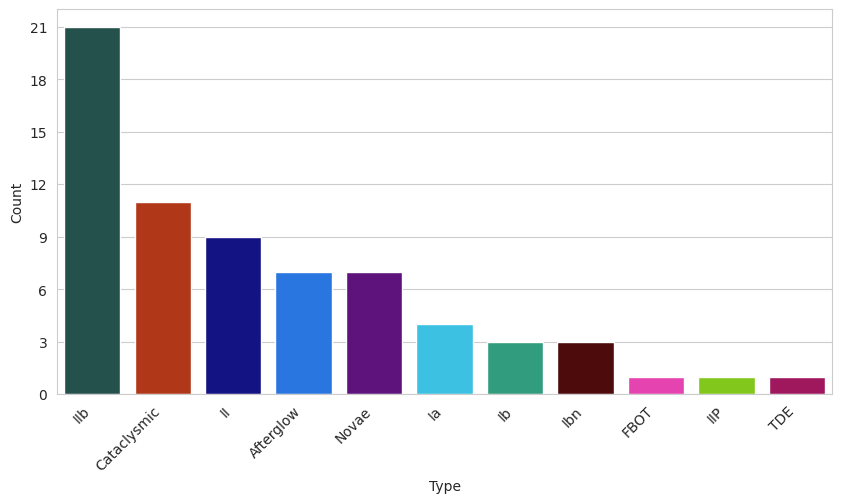

In [8]:
from matplotlib.ticker import MaxNLocator
type_counts = df_rates[df_rates.type != 'Kilonova']['type'].value_counts()
sorted_types = type_counts.index
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.set_style('whitegrid')
sns.countplot(data=df_rates[df_rates.type != 'Kilonova'], x='type', order=sorted_types, palette=colors_dict, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# sns.set(style='whitegrid')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.grid(axis='y')
ax.set_ylim(0,22)
plt.savefig(f'figures/type_distribution{ext}', bbox_inches='tight') if savefigs else None
plt.show()

Color at Peak

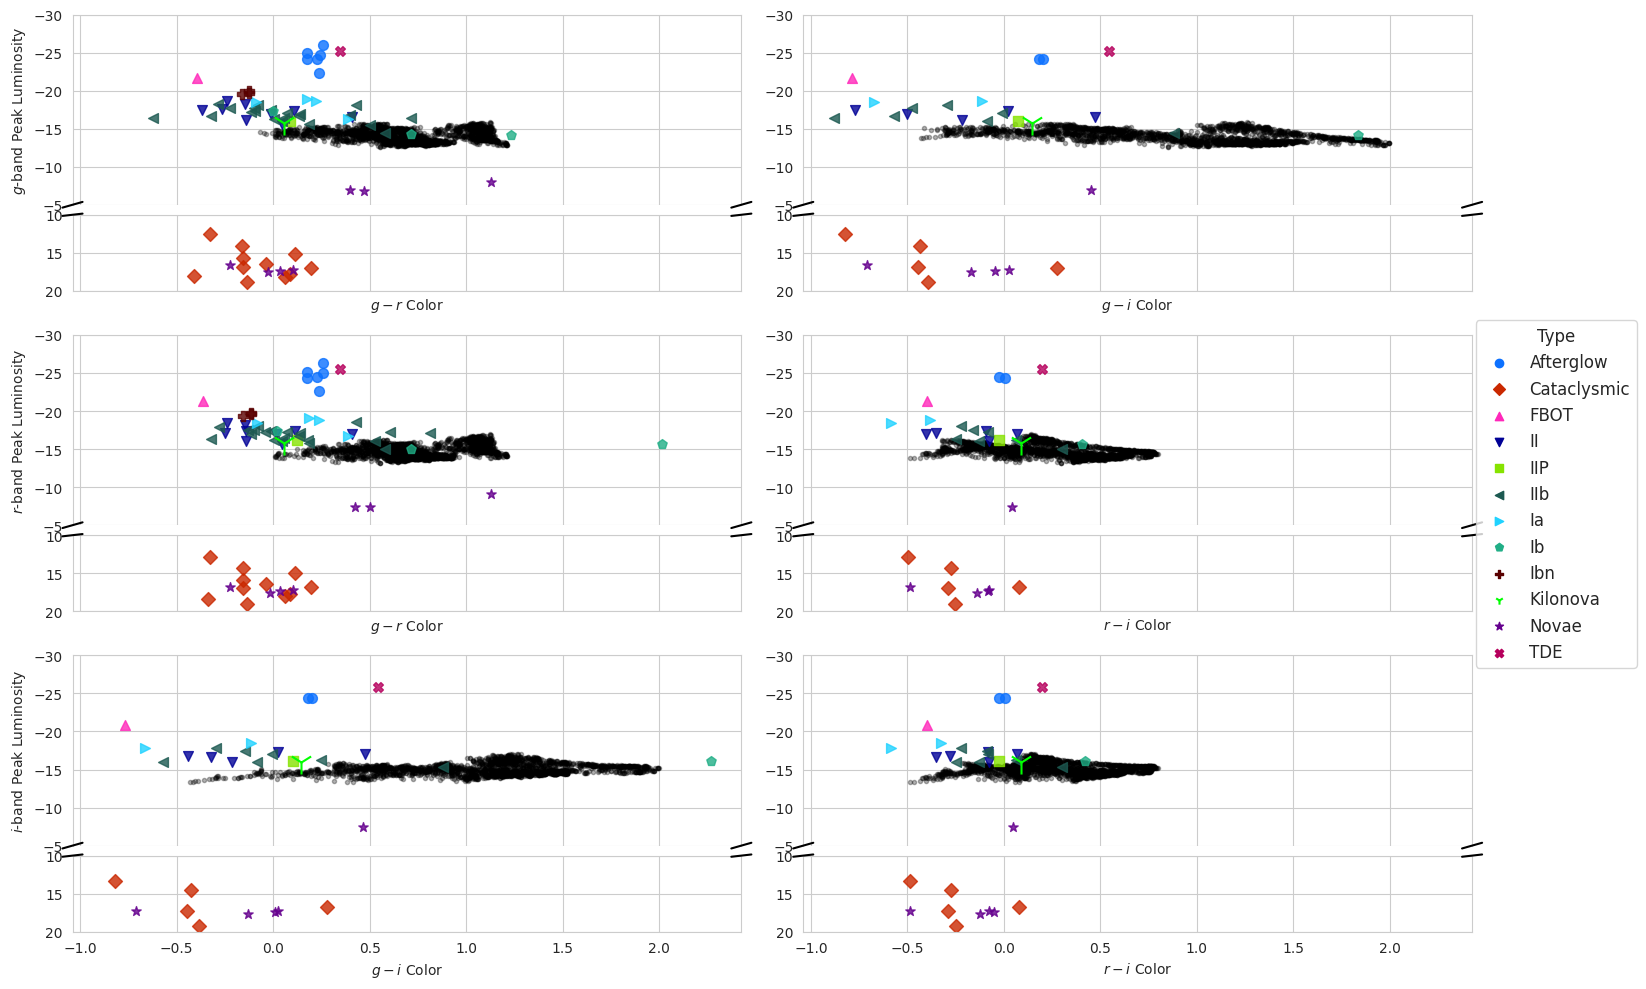

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

axs = axs.flatten()

peaks = ['ztfg_peak_gr_color', 'ztfg_peak_gi_color', 
         'ztfr_peak_gr_color', 'ztfr_peak_ri_color', 
         'ztfi_peak_gi_color', 'ztfi_peak_ri_color']
axs2 = []
for ax, peak in zip(axs, peaks):
    ax.invert_yaxis()
    filter = peak.split('_')[0]
    #color = peak.split('_')[-2]
    # Create the broken axis
    divider = make_axes_locatable(ax)
    ax2 = divider.new_vertical(size="250%", pad=0.1)
    fig.add_axes(ax2)
    ax2.sharex(ax)
    axs2.append(ax2)
    
    # Set the y-limits for each axis
    ax.set_ylim(20, 10)
    ax2.set_ylim(-5, -30)
    
    # Hide unnecessary spines and ticks
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.spines['bottom'].set_visible(False)

    # Add diagonal lines to indicate the break
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False,zorder=100)
    ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
    ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
    
    
    # Plot the data on both axes
    ax.scatter(df_2019[peak], df_2019[f'{filter}_peak_mag'], alpha=0.3, color='k', marker='.')
    ax2.scatter(df_2019[peak], df_2019[f'{filter}_peak_mag'], alpha=0.3, color='k', marker='.')

    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax.scatter(df_class[peak], df_class[f'{filter}_peak_mag'], 
                       color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
            ax2.scatter(df_class[peak], df_class[f'{filter}_peak_mag'], 
                       color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
            


## add legend to the right of the plots using the type_style_dict colors and markers (base on all of the subplots)
handles, labels = [], []
for ax in axs:
    for type_ in df_rates['type'].unique():
        handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker']))
        labels.append(type_)
handles = handles[:len(df_rates['type'].unique())]
labels = labels[:len(df_rates['type'].unique())]
fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.1, 0.5),)

axs2[0].set_ylabel("$\it{g}$-band Peak Luminosity"), axs2[2].set_ylabel("$\it{r}$-band Peak Luminosity"), axs2[4].set_ylabel("$\it{i}$-band Peak Luminosity"); 

axs[0].set_xlabel("$\it{g-r}$ Color"), axs[1].set_xlabel("$\it{g-i}$ Color"); 
axs[2].set_xlabel("$\it{g-r}$ Color"), axs[3].set_xlabel("$\it{r-i}$ Color"); 
axs[4].set_xlabel("$\it{g-i}$ Color"), axs[5].set_xlabel("$\it{r-i}$ Color"); 
ax.figure.tight_layout() 
plt.savefig(f'figures/peak_color_vs_peak_mag_broken_axis{ext}', bbox_inches='tight') if savefigs else None 
plt.show();

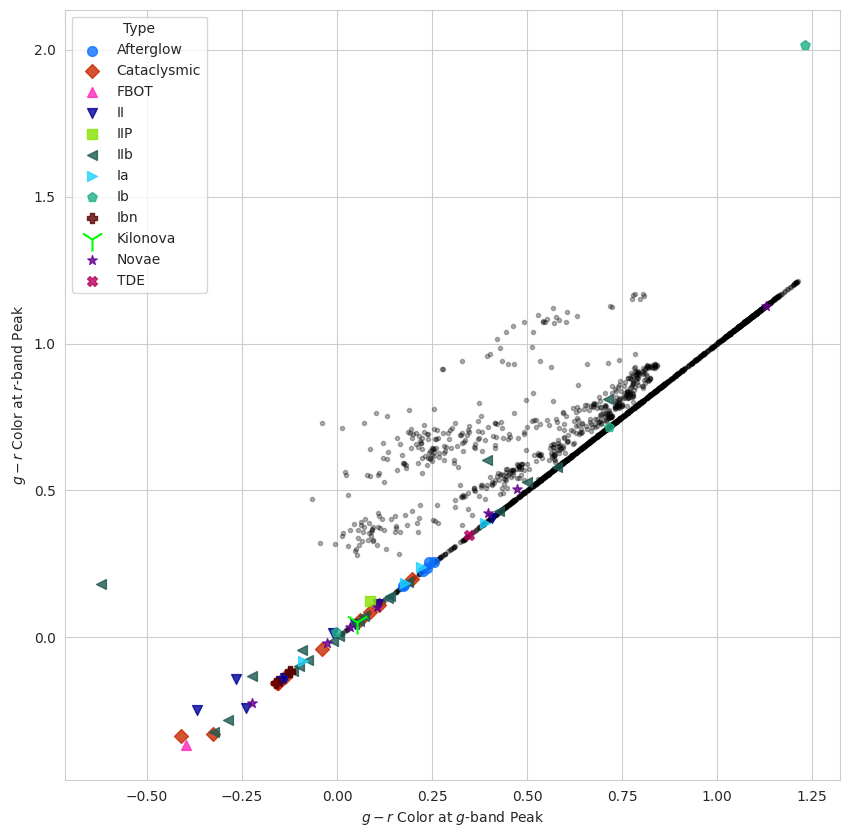

In [10]:
## compare the gr color at the peak of ztfg and the peak of ztfr
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.invert_yaxis()
ax.scatter(df_2019['ztfg_peak_gr_color'], df_2019['ztfr_peak_gr_color'], alpha=0.3, color='k',marker='.')

for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_peak_gr_color'].notnull()) & (df_rates['ztfr_peak_gr_color'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class['ztfg_peak_gr_color'], df_class['ztfr_peak_gr_color'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
ax.legend(title='Type')
ax.set_xlabel("$\it{g-r}$ Color at $\it{g}$-band Peak")
ax.set_ylabel("$\it{g-r}$ Color at $\it{r}$-band Peak")
plt.savefig(f'figures/gr_color_at_g_vs_r_peak{ext}', bbox_inches='tight') if savefigs else None
plt.show();

FWHM vs Peak Magnitude

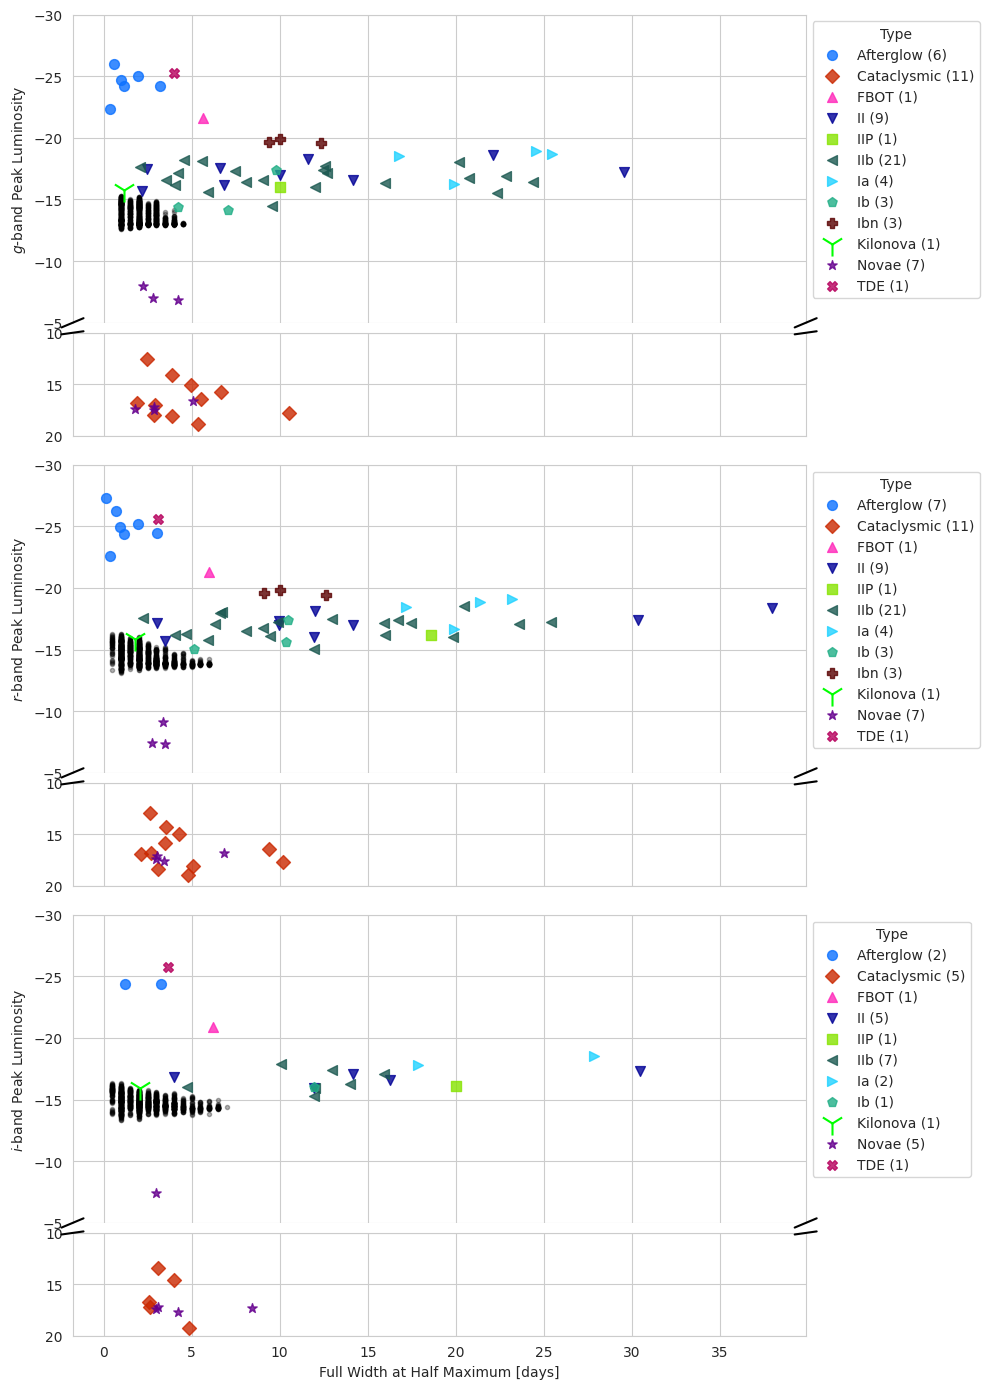

In [11]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 14), 
                       sharex=True,sharey=True, tight_layout=True)
axs2 = []
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].invert_yaxis()
    #filter = peak.split('_')[0]
    #color = peak.split('_')[-2]
    # Create the broken axis
    divider = make_axes_locatable(ax[axi])
    ax2 = divider.new_vertical(size="300%", pad=0.1)
    fig.add_axes(ax2)
    ax2.sharex(ax[axi])
    axs2.append(ax2)
    # Set the y-limits for each axis
    ax[axi].set_ylim(20, 10)
    ax2.set_ylim(-5, -30)
    
    # Hide unnecessary spines and ticks
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.spines['bottom'].set_visible(False)

    # Add diagonal lines to indicate the break
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False,zorder=100)
    ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[axi].transAxes)  # switch to the bottom axes
    ax[axi].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[axi].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    ax[axi].scatter(df_2019[f'{filter}_fwhm'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    ax2.scatter(df_2019[f'{filter}_fwhm'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():

        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fwhm'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_fwhm'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
            ax2.scatter(df_class[f'{filter}_fwhm'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();

class_counts_ztfg = df_rates[df_rates['ztfg_fwhm'].notnull() & df_rates['ztfg_peak_mag'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fwhm'].notnull() & df_rates['ztfr_peak_mag'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fwhm'].notnull() & df_rates['ztfi_peak_mag'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs2, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")

    
axs2[0].set_ylabel("$\it{g}$-band Peak Luminosity"), axs2[1].set_ylabel("$\it{r}$-band Peak Luminosity"), axs2[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Full Width at Half Maximum [days]");
#ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
#ax[0].set_xlim(None,-2.0)
plt.savefig(f'figures/fwhm_vs_peak_luminosity_broken{ext}', bbox_inches='tight') if savefigs else None

plt.show()

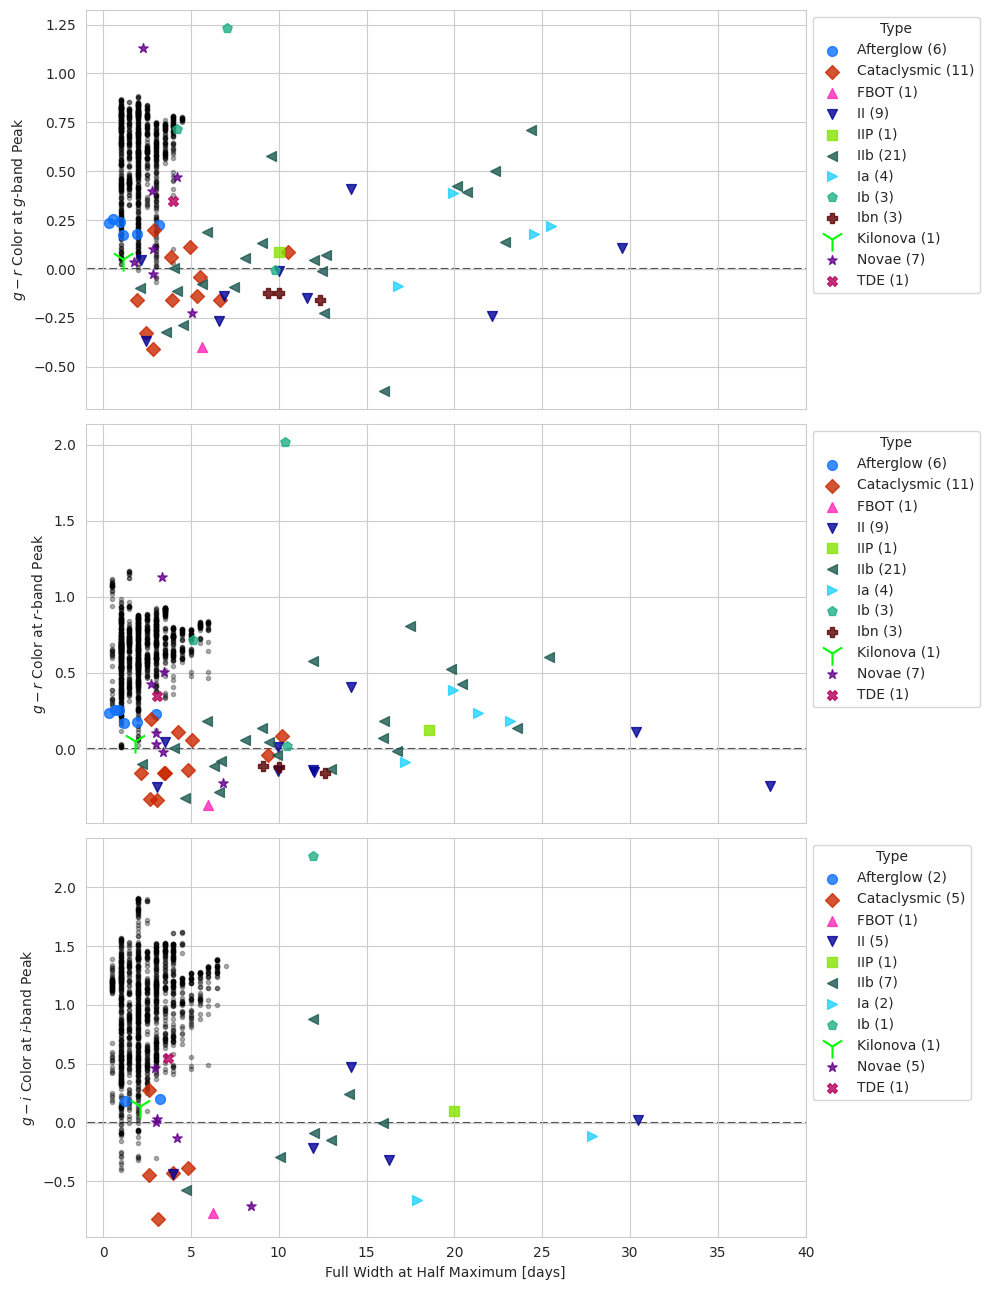

In [12]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 13), tight_layout=True,
                       sharex=True)#,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()


x_array = ['ztfg_fwhm', 'ztfr_fwhm', 'ztfi_fwhm']
y_array = ['ztfg_peak_gr_color', 'ztfr_peak_gr_color', 'ztfi_peak_gi_color']
for axi, (x, y) in enumerate(zip(x_array, y_array)):

    ax[axi].hlines(0, -50, 50, color='k', linestyle='--', alpha=0.7,zorder=0)
    ax[axi].scatter(df_2019[x], df_2019[y], alpha=0.3,color='k',marker='.')
    df_class = df_rates[(df_rates[x].notnull()) & (df_rates[y].notnull())]

    for type_ in df_rates['type'].unique():
        df_class_type = df_class[df_class['type'] == type_]
        if len(df_class_type) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class_type[x],  df_class_type[y],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();

class_counts_ztfg = df_rates[(df_rates['ztfg_fwhm'].notnull()) & (df_rates['ztfg_peak_gr_color'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fwhm'].notnull() & df_rates['ztfr_peak_gr_color'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fwhm'].notnull() & df_rates['ztfi_peak_gi_color'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
# ax[0].set_ylabel("$\it{g-r}$ Color at $\it{g}$-band Peak"), ax[1].set_ylabel("$\it{r-g}$ Color at $\it{r}$-band Peak"), ax[2].set_ylabel("$\it{i-g}$ Color at $\it{i}$-band Peak") ## without color factor labels
ax[0].set_ylabel("$\it{g-r}$ Color at $\it{g}$-band Peak"), ax[1].set_ylabel("$\it{g-r}$ Color at $\it{r}$-band Peak"), ax[2].set_ylabel("$\it{g-i}$ Color at $\it{i}$-band Peak")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Full Width at Half Maximum [days]");
ax[0].set_xlim(-1, 40)

plt.savefig(f'figures/fwhm_vs_peak_color{ext}', bbox_inches='tight') if savefigs else None
plt.show()

In [13]:
# ## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
# filters = ['ztfg', 'ztfr', 'ztfi']

# ## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
# fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
#                        sharex=True)
# # ax[0].grid(), ax[1].grid(), ax[2].grid()
# for axi, filter in enumerate(filters):
#     # ax[axi].hist(df_2019[f'{filter}_fwhm'], color='k',bins=50, density=True)
#     # sns.histplot(df_2019.sample(n=69,random_state=1), x=f'{filter}_fwhm', color='k',  ax=ax[axi], alpha=0.7, stat='count',kde=True)
#     # sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, bins=50, ax=ax[axi], alpha=1, stat='count', multiple='stack', legend=False)
    
#     sns.histplot(df_2019, x=f'{filter}_fwhm', color='k',  ax=ax[axi], alpha=0.7, stat='proportion',kde=True)
#     sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, bins=50, ax=ax[axi], alpha=1, stat='proportion', multiple='stack', legend=False)
    
    
# handles, labels = [], []
# for ax in axs:
#     for type_ in df_rates['type'].unique():
#         handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker='o'))
#         labels.append(type_)
# handles = handles[:len(df_rates['type'].unique())]
# labels = labels[:len(df_rates['type'].unique())]
# lgnd = fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.17, 0.5),);
# for item in lgnd.legendHandles:
#     item._sizes = [100]


In [14]:
# from matplotlib.ticker import MaxNLocator
# ## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
# filters = ['ztfg', 'ztfr', 'ztfi']

# ## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
# fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
#                        sharex=True,)
# # ax[0].grid(), ax[1].grid(), ax[2].grid()
# ax[0].set_ylabel("$\it{g}$-band Count"), ax[1].set_ylabel("$\it{r}$-band Count"), ax[2].set_ylabel("$\it{i}$-band Count")  
# ax[2].set_xlabel("Full Width at Half Maximum [days]");
# for axi, filter in enumerate(filters):
#     # ax[axi].hist(df_2019[f'{filter}_fwhm'], color='k',bins=50, density=True)
#     sns.histplot(df_2019.sample(n=69,random_state=1), x=f'{filter}_fwhm', color='k',  binwidth=1, ax=ax[axi], alpha=0.7, stat='count',kde=True)
#     sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, binwidth=1, ax=ax[axi], alpha=1, stat='count', multiple='stack', legend=False)
    
#     # sns.histplot(df_2019, x=f'{filter}_fwhm', color='k',  ax=ax[axi], alpha=0.7, stat='proportion',kde=True)
#     # sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, bins=50, ax=ax[axi], alpha=1, stat='proportion', multiple='stack', legend=False)
# ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))   
  
# handles, labels = [], []
# for ax in axs:
#     for type_ in df_rates['type'].unique():
#         handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker='o'))
#         labels.append(type_)
# handles = handles[:len(df_rates['type'].unique())]
# labels = labels[:len(df_rates['type'].unique())]
# lgnd = fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.17, 0.5),);
# for item in lgnd.legendHandles:
#     item._sizes = [100]



# plt.savefig(f'figures/fwhm_hist_count{ext}', bbox_inches='tight') if savefigs else None

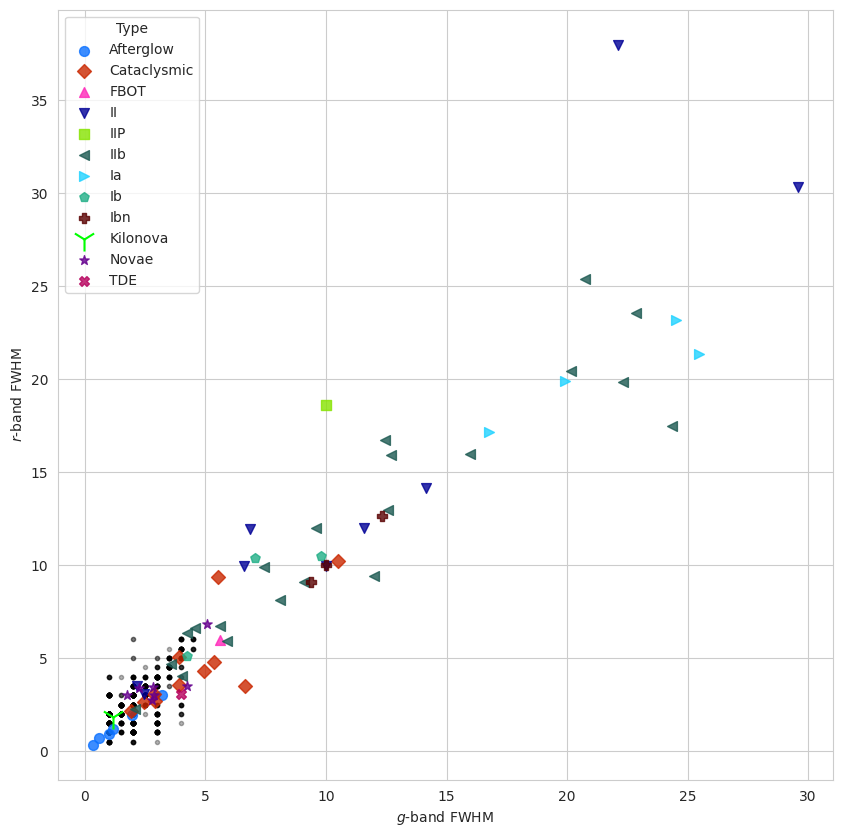

In [15]:
## compare the gr color at the peak of ztfg and the peak of ztfr
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.invert_yaxis()
# ax.grid()
ax.scatter(df_2019['ztfg_fwhm'], df_2019['ztfr_fwhm'], alpha=0.3, color='k',marker='.')

for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fwhm'].notnull()) & (df_rates['ztfr_fwhm'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class['ztfg_fwhm'], df_class['ztfr_fwhm'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
ax.legend(title='Type')
ax.set_xlabel("$\it{g}$-band FWHM");
ax.set_ylabel("$\it{r}$-band FWHM");
# plt.savefig(f'figures/ztfg_fwhm_vs_ztfr_fwhm{ext}', bbox_inches='tight')
plt.show();

Rise vs Peak Magnitude

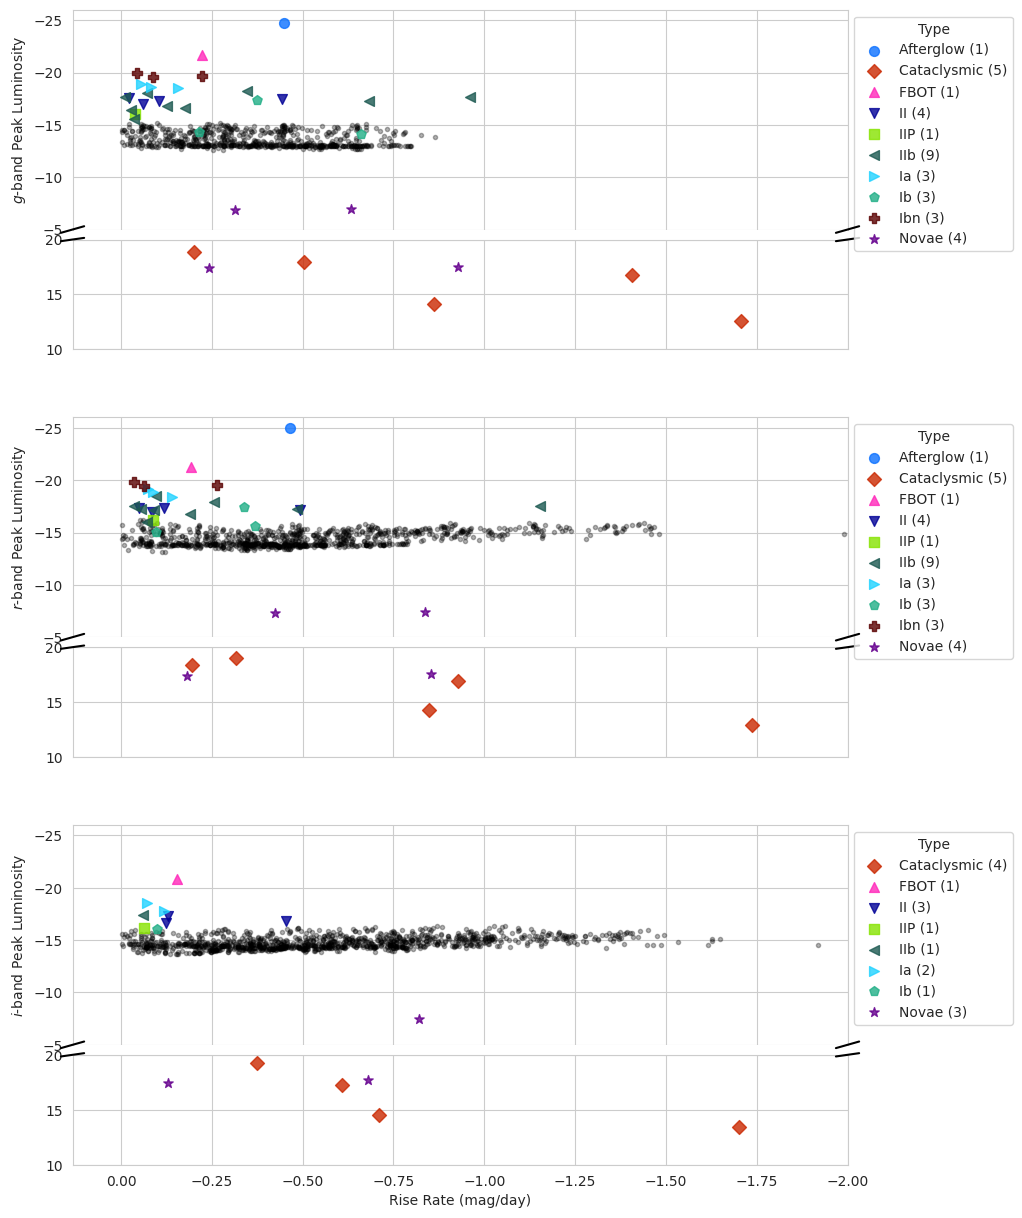

In [16]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
axs2 = []
for axi, filter in enumerate(filters):
    ax[axi].invert_yaxis()
    #filter = peak.split('_')[0]
    #color = peak.split('_')[-2]
    # Create the broken axis
    divider = make_axes_locatable(ax[axi])
    ax2 = divider.new_vertical(size="200%", pad=0.1)
    fig.add_axes(ax2)
    ax2.sharex(ax[axi])
    axs2.append(ax2)
    # Set the y-limits for each axis
    ax[axi].set_ylim(20, 10)
    ax2.set_ylim(-5, -26)
    
    # Hide unnecessary spines and ticks
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.spines['bottom'].set_visible(False)

    # Add diagonal lines to indicate the break
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False,zorder=100)
    ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[axi].transAxes)  # switch to the bottom axes
    ax[axi].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[axi].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    ax2.scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_rise_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
            ax2.scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs2, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
axs2[0].set_ylabel("$\it{g}$-band Peak Luminosity"), axs2[1].set_ylabel("$\it{r}$-band Peak Luminosity"), axs2[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(None,-2.0)
plt.savefig(f'figures/rise_rate_vs_peak_luminosity_broken{ext}', bbox_inches='tight') if savefigs else None
plt.show()

Fade vs Peak Magnitude

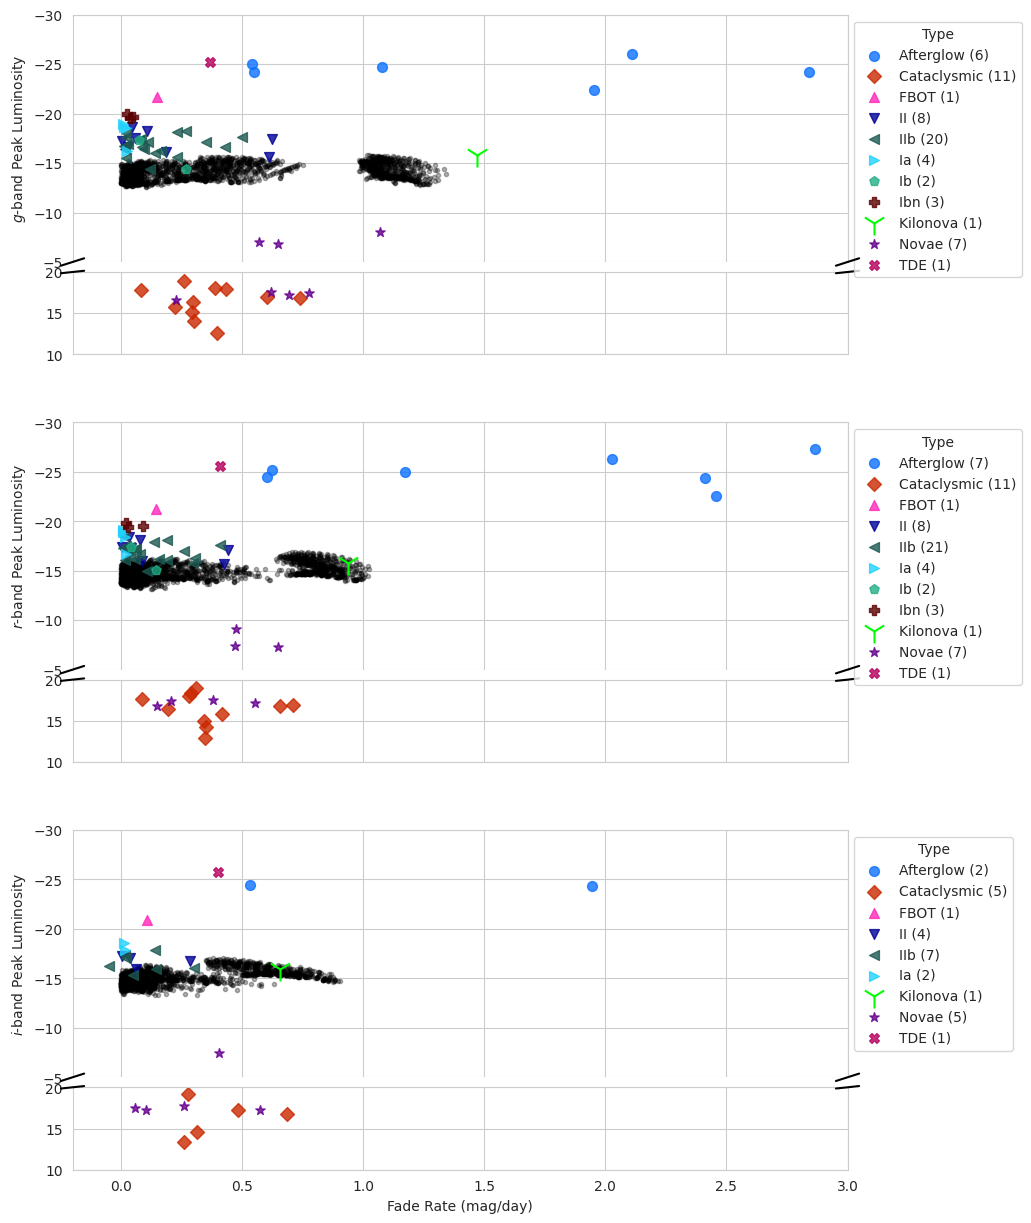

In [17]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
axs2 = []
for axi, filter in enumerate(filters):
    ax[axi].invert_yaxis()
    #filter = peak.split('_')[0]
    #color = peak.split('_')[-2]
    # Create the broken axis
    divider = make_axes_locatable(ax[axi])
    ax2 = divider.new_vertical(size="300%", pad=0.1)
    fig.add_axes(ax2)
    ax2.sharex(ax[axi])
    axs2.append(ax2)
    # Set the y-limits for each axis
    ax[axi].set_ylim(20, 10)
    ax2.set_ylim(-5, -30)
    
    # Hide unnecessary spines and ticks
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.spines['bottom'].set_visible(False)

    # Add diagonal lines to indicate the break
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False,zorder=100)
    ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[axi].transAxes)  # switch to the bottom axes
    ax[axi].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[axi].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    ax[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    ax2.scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fade_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
            ax2.scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs2, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
axs2[0].set_ylabel("$\it{g}$-band Peak Luminosity"), axs2[1].set_ylabel("$\it{r}$-band Peak Luminosity"), axs2[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Fade Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(-0.2,3.0)
plt.savefig(f'figures/fade_rate_vs_peak_luminosity_broken{ext}', bbox_inches='tight') if savefigs else None
plt.show()

Rise vs Fade

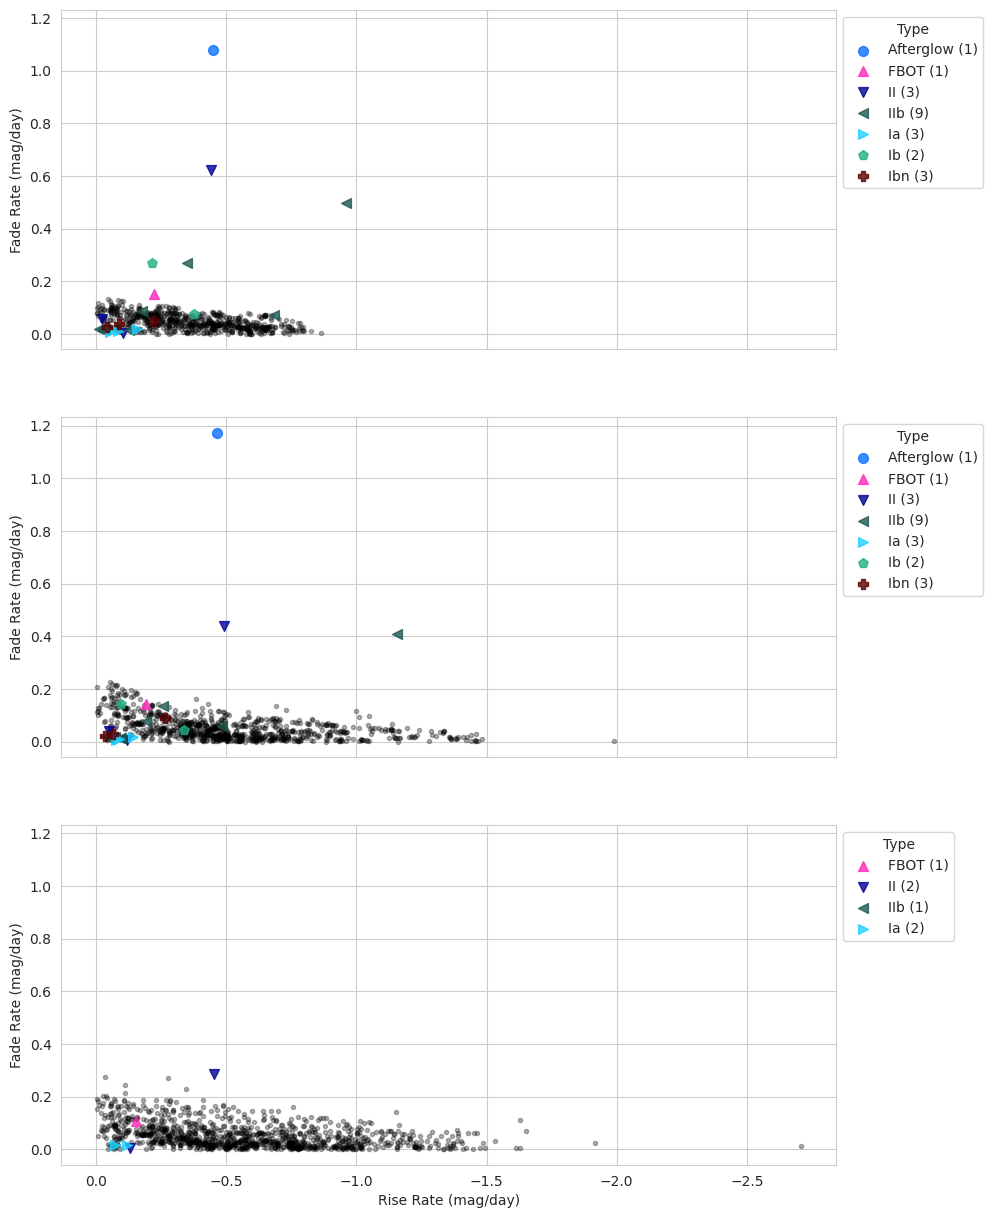

In [18]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_fade_rate'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_fade_rate'].notnull()) & (df_rates_far[f'{filter}_rise_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_fade_rate'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', hue='type', style='type', s=150, ax=ax[axi])

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfg_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[(df_rates['ztfr_rise_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[(df_rates['ztfi_rise_rate'].notnull()) & (df_rates['ztfi_fade_rate'].notnull())]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("Fade Rate (mag/day)"), ax[1].set_ylabel("Fade Rate (mag/day)"), ax[2].set_ylabel("Fade Rate (mag/day)")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
plt.savefig(f'figures/rise_rate_vs_fade_rate{ext}', bbox_inches='tight') if savefigs else None
plt.show()

g-band rise vs r-band rise & g-band fade vs r-band fade

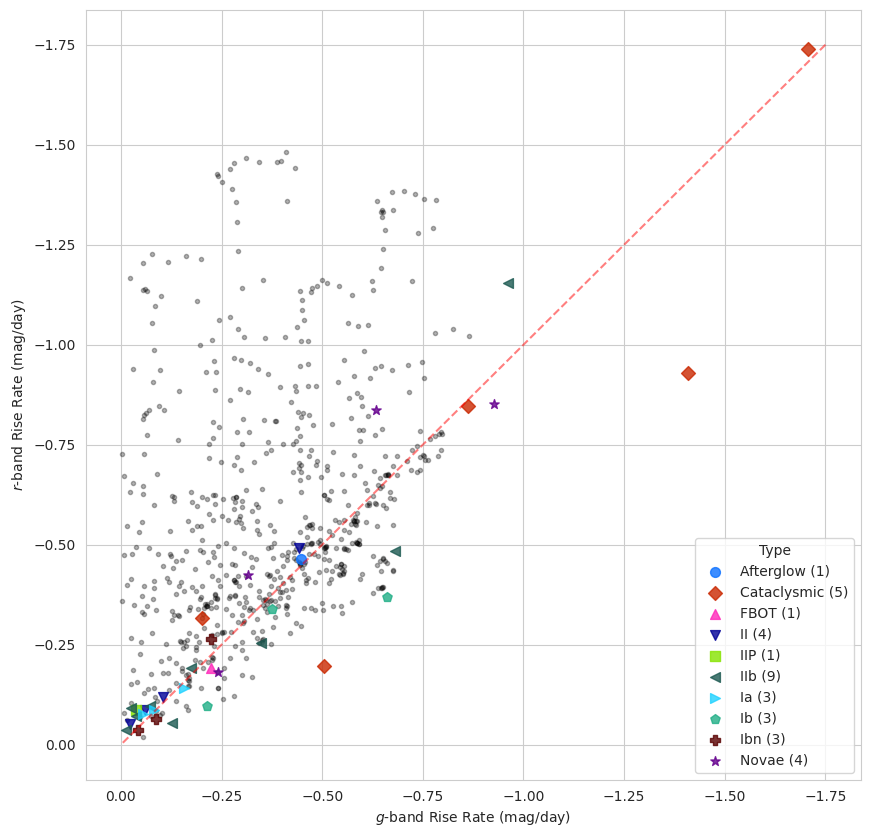

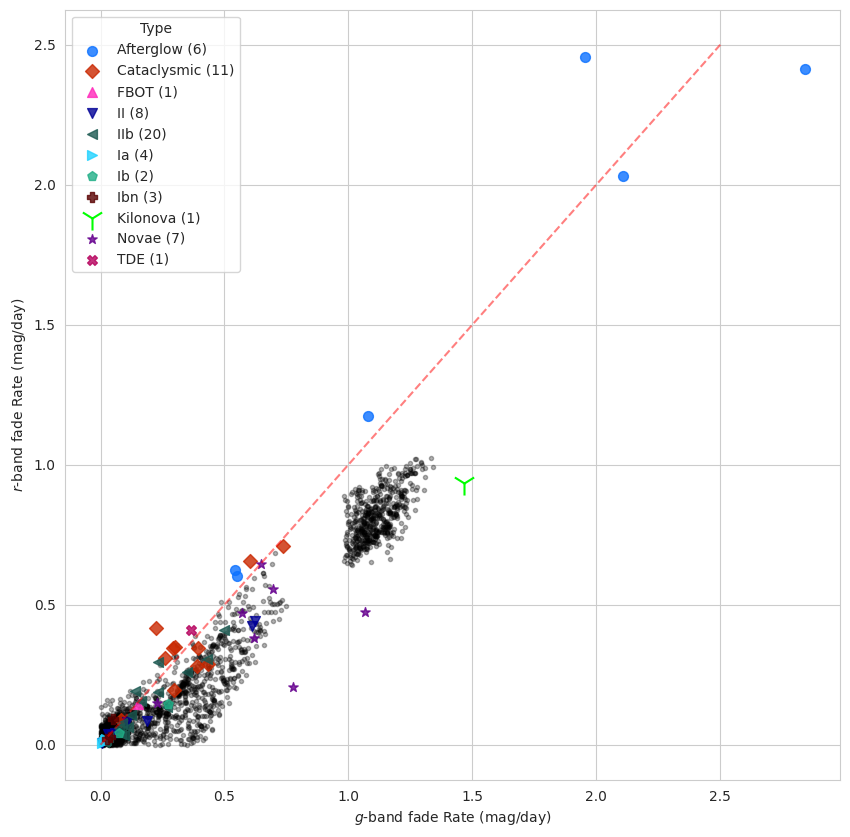

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
# ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfg_rise_rate'], df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfr_rise_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(-1.75,0,100), np.linspace(-1.75,0,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class[f'ztfg_rise_rate'], df_class[f'ztfr_rise_rate'],
                        color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                            s=s_, alpha=a_, label=type_, zorder=z_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
ax.set_ylabel("$\it{r}$-band Rise Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band Rise Rate (mag/day)");
#plt.savefig(f'figures/ztfg_rise_rate_vs_ztfr_rise_rate{ext}', bbox_inches='tight')
ax.invert_xaxis(), ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
# ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfg_fade_rate'], df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfr_fade_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class[f'ztfg_fade_rate'], df_class[f'ztfr_fade_rate'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
#ax.invert_xaxis(), ax.invert_yaxis()

ax.set_ylabel("$\it{r}$-band fade Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band fade Rate (mag/day)");
plt.savefig(f'figures/ztfg_fade_rate_vs_ztfr_fade_rate{ext}', bbox_inches='tight') if savefigs else None

plt.show()

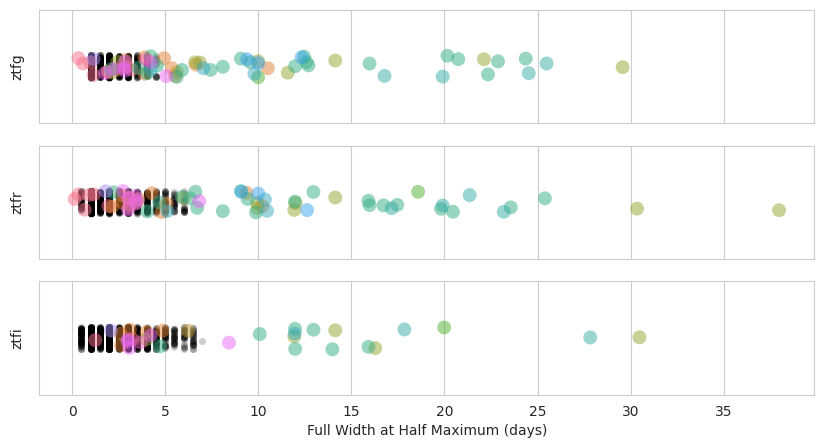

In [20]:
## stripplot of the rise rate for each filter including the kilonova model
fig, ax = plt.subplots(3, 1, figsize=(10, 5), 
                       sharex=True,sharey=True)
for axi, filter in enumerate(filters):
    sns.stripplot(data=df_2019, x=f'{filter}_fwhm', ax=ax[axi], alpha=0.2, color='k')
    sns.stripplot(data=df_rates, x=f'{filter}_fwhm', ax=ax[axi], alpha=0.5, hue='type', s=10, legend=False)
    ax[axi].set_ylabel(f"{filter}")
    ax[axi].set_xlabel("Full Width at Half Maximum (days)")
    # ax[axi].invert_xaxis()
    # ax[axi].invert_yaxis()
    # ax[axi].set_xlim(0.1,-2)

## Metric Distances Experiment

In [21]:
# def metric_distance_2d(object, model_data):
#     '''
#     Finds the average distance between an object and model data. 
    
#     Args:
#     object (tuple): tuple containing an object's two metrics (x,y)
#     model_data (list): list of tuples containing the model data's metrics (x,y)
    
#     Returns:
#     distance (float): average distance between object and model_data
#     '''
#     distance_array = np.array([np.sqrt((object[0] - model[0])**2 + (object[1] - model[1])**2) for model in model_data])
#     distance_array = distance_array[~np.isnan(distance_array)]
#     # print(distance_array)
#     distance = np.mean(distance_array)
#     return distance

def metric_distance(object, model_data, raw=False):
    '''
    Finds the average distance between the object and model data in n-dimensional space.
    
    Args:
    object (tuple): tuple containing an object's metrics
    model_data (list): list of tuples containing the model data's metrics
    raw (bool): if True, returns the raw distance array
    
    Returns:
    distance (float): average distance between object and model_data
    '''
    # print(object)
    # print(model_data)
    # print(type(object))
    # print(type(model_data))
    if type(object) != np.ndarray:
        object = np.array([object])
    if type(model_data) != np.ndarray:
        model_data = np.array([model_data])
    # if len(object) != len(model_data[0]):
    #     raise ValueError('The object and model data must have the same number of dimensions')
    if len(object) == 1:
        distance_array = np.abs(object - model_data) 
    else:
        distance_array = np.sqrt(np.sum((object - model_data)**2, axis=1))
    
    #distance_array = distance_array[~np.isnan(distance_array)]
    distance = np.mean(distance_array) if not raw else distance_array
    return distance


In [22]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [23]:
display(df_rates)
display(df_2019)

,obj_id,type,category,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,...,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
33,ZTF21aagwbjr,Afterglow,Afterglow,0.87600,0.000000,-24.205266,0.000000,-24.432682,0.000000,-24.408692,...,NaN,NaN,NaN,NaN,1.956493,0.551079,1.956493,0.601270,1.956493,0.532761
27,ZTF20acozryr,Afterglow,Afterglow,1.10500,0.000000,-24.982499,0.000000,-25.159879,NaN,NaN,...,NaN,NaN,NaN,NaN,0.976551,0.541711,0.976551,0.622483,NaN,NaN
38,ZTF21abfmpwn,Afterglow,Afterglow,1.13450,0.000000,-25.995617,0.000000,-26.251762,NaN,NaN,...,NaN,NaN,NaN,NaN,1.101111,2.108729,1.101111,2.029503,NaN,NaN
59,ZTF23aaxeacr,Afterglow,Afterglow,0.36000,0.000000,-22.360613,0.000000,-22.596908,NaN,NaN,...,NaN,NaN,NaN,NaN,0.170266,1.955179,0.170266,2.455553,NaN,NaN
57,ZTF23aaoohpy,Afterglow,Afterglow,1.02700,0.244034,-24.708486,0.181406,-24.958452,NaN,NaN,...,0.181406,-0.464425,NaN,NaN,0.834682,1.079221,0.897310,1.172814,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,ZTF23abgsmsg,Novae,Galactic,0.00000,2.105722,17.531687,2.203663,17.555114,2.350573,17.688440,...,2.203663,-0.852574,2.350573,-0.679010,1.958811,0.618267,1.958811,0.380247,1.958811,0.258340
49,ZTF22abijszk,Novae,Galactic,0.00100,0.000000,-8.016094,0.000000,-9.144732,NaN,NaN,...,NaN,NaN,NaN,NaN,1.934028,1.067826,1.934028,0.475787,NaN,NaN
48,ZTF22abfxmpc,Novae,Galactic,0.00000,0.793516,17.399762,0.793516,17.365459,1.058021,17.436970,...,0.793516,-0.183027,1.058021,-0.128745,1.983790,0.778070,1.983790,0.206140,1.939705,0.056325
46,ZTF22aazmooy,Novae,Galactic,0.00017,1.462144,-6.973774,1.305485,-7.384998,1.357705,-7.431442,...,1.305485,-0.837569,1.357705,-0.821712,1.984338,0.568944,1.984338,0.469871,1.984338,0.406810


,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfg_fwhm,ztfg_rise_hwhm,ztfg_fade_hwhm,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,...,ztfi_rise_hwhm,ztfi_fade_hwhm,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_gr_color,ztfr_peak_ri_color,ztfi_peak_gi_color,ztfi_peak_ri_color,model,obj_id
0,-14.803,0.5,NaN,1.182000,NaN,NaN,NaN,-15.659,0.5,NaN,...,NaN,NaN,0.856,0.903,0.856,0.047,0.903,0.047,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0
1,-14.730,0.5,NaN,1.165333,NaN,NaN,NaN,-15.582,0.5,NaN,...,NaN,NaN,0.852,0.903,0.852,0.051,0.903,0.051,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta25.84_d...
2,-14.655,0.5,NaN,1.149333,NaN,NaN,NaN,-15.505,0.5,NaN,...,NaN,NaN,0.850,0.910,0.850,0.060,0.910,0.060,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta36.87_d...
3,-14.578,0.5,NaN,1.130000,NaN,NaN,NaN,-15.429,0.5,NaN,...,NaN,NaN,0.851,0.913,0.851,0.062,0.913,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta45.57_d...
4,-14.501,0.5,NaN,1.108000,NaN,NaN,NaN,-15.355,0.5,NaN,...,NaN,NaN,0.854,0.916,0.854,0.062,0.916,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta53.13_d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,4.5,1.0,3.5,-13.853,3.0,-0.7204,...,1.5,5.0,0.762,1.264,0.837,0.512,1.380,0.526,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta66.42_d...
2196,-13.039,2.5,-0.7495,0.016667,4.5,1.0,3.5,-13.845,3.0,-0.7248,...,1.5,5.0,0.771,1.273,0.831,0.515,1.389,0.537,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta72.54_d...
2197,-13.029,2.5,-0.7520,0.010667,4.5,1.0,3.5,-13.841,3.0,-0.7208,...,1.5,5.0,0.779,1.278,0.828,0.514,1.386,0.534,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta78.46_d...
2198,-13.029,2.5,-0.7565,0.014000,4.5,1.0,3.5,-13.841,3.0,-0.7120,...,1.5,5.0,0.776,1.277,0.833,0.513,1.384,0.530,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta84.26_d...


In [24]:
def calc_radar_data(df_objects, df_grid, grouping='type', metrics='all'):
    '''
    Calculates the average distance between each object type and the model data for each metric. The average for each metric is calculated by taking the average of the distance to all points in the model data to all objects in a given object type to prevent taking an average of an average.
    
    Args:
    df_objects (pd.DataFrame): DataFrame containing the object metrics
    df_grid (pd.DataFrame): DataFrame containing the model data
    metrics (list): list of metrics to calculate the distance for. If 'all', calculates the distance for all metrics
    
    Returns:
    radar_data (pd.DataFrame): DataFrame containing the average distance between each object type and the model data for each metric. Each row corresponds to a different object type and each column corresponds to a different metric. If a given object type does not have measurements in that metric, that index is NaN.
    '''
    
    types_ = df_objects[grouping].unique().tolist()
    metrics_ = df_grid.columns.tolist()[:-2] if metrics == 'all' else metrics
    
    df_radar_data = pd.DataFrame(index=types_, columns=metrics_)
    for type_ in types_:
        df_type = df_objects[df_objects[grouping] == type_]
        for metric in metrics_:
            df_type_metric = np.array(df_type[metric].dropna().tolist())
            df_grid_metric = np.array(df_grid[metric].dropna().tolist())
            if len(df_type_metric) == 0:
                df_radar_data.loc[type_, metric] = 0
                continue
            else:
                radar_data = [metric_distance(obj_, df_grid_metric, raw=True) for obj_ in df_type_metric]
                radar_data = np.mean(radar_data)
                df_radar_data.loc[type_, metric] = radar_data
            
    return df_radar_data

In [25]:
def format_radar_data(df_radar_data):
    '''
    Formats the radar data for plotting
    
    Args:
    df_radar_data (pd.DataFrame): DataFrame containing the average distance between each object type and the model data for each metric. Each row corresponds to a different object type and each column corresponds to a different metric. If a given object type does not have measurements in that metric, that index is NaN.
    
    Returns:
    radar_data (array): an array formatted for the radar plot. The structure is as follows:
    - first index in the array is an array with the object types, which is the index of the input DataFrame
    - subsequent indices are lists that each correspond to a different metrics. Each list is structured in the general format ('metric_name',[[x,x,x,x,x]])
    '''
    radar_data = []
    radar_data.append(df_radar_data.index.tolist())
    for metric in df_radar_data.columns:
        radar_data.append((metric, [df_radar_data[metric].tolist()]))
    return radar_data


In [26]:
df_2019.columns

Index(['ztfg_peak_mag', 'ztfg_peak_time', 'ztfg_rise_rate', 'ztfg_fade_rate',
       'ztfg_fwhm', 'ztfg_rise_hwhm', 'ztfg_fade_hwhm', 'ztfr_peak_mag',
       'ztfr_peak_time', 'ztfr_rise_rate', 'ztfr_fade_rate', 'ztfr_fwhm',
       'ztfr_rise_hwhm', 'ztfr_fade_hwhm', 'ztfi_peak_mag', 'ztfi_peak_time',
       'ztfi_rise_rate', 'ztfi_fade_rate', 'ztfi_fwhm', 'ztfi_rise_hwhm',
       'ztfi_fade_hwhm', 'ztfg_peak_gr_color', 'ztfg_peak_gi_color',
       'ztfr_peak_gr_color', 'ztfr_peak_ri_color', 'ztfi_peak_gi_color',
       'ztfi_peak_ri_color', 'model', 'obj_id'],
      dtype='object')

In [27]:
radar_metrics_ = [
'ztfg_peak_mag',
'ztfr_peak_mag',
'ztfi_peak_mag',
'ztfg_rise_rate',
'ztfr_rise_rate',
'ztfi_rise_rate',
'ztfg_fade_rate',
'ztfr_fade_rate',
'ztfi_fade_rate',
'ztfg_fwhm',
'ztfr_fwhm',
'ztfi_fwhm',
'ztfg_peak_gr_color',
'ztfg_peak_gi_color',
'ztfr_peak_gr_color',
'ztfr_peak_ri_color',
'ztfi_peak_gi_color',
'ztfi_peak_ri_color',
]

In [28]:
# def gen_radar_data(df_objects, df_grid, metrics='all'):
#     '''
#     Generates the radar data for each object in df_objects using the metrics in metrics.
    
#     Args:
#     df_objects (pd.DataFrame): dataframe containing the objects
#     df_grid (pd.DataFrame): dataframe containing the grid data
#     metrics (list): list of metrics to use. If 'all', all metrics will be calculated
    
#     Returns:
#     radar_data (list): list of radar data for each object
#     '''
#     types_ = df_objects['type'].unique().tolist()
#     radar_data = [types_]
#     if metrics == 'all' or metrics == ['all']:
#         metrics = df_objects.columns.tolist()[3:]
#         metrics = np.array([metric for metric in metrics if metric in df_grid.columns]).tolist()
#         metrics = np.array([metric for metric in metrics if metric not in ['obj_id', 'type', 'redshift','model', 'ztfg_peak_time', 'ztfr_peak_time', 'ztfi_peak_time']]).tolist()
    
#     metric_data = []
#     objects_np = df_objects[metrics].values
#     ##print(objects_np)
#     grid_np = df_grid[metrics].values 
#     for metric_idx, metric in enumerate(metrics):
#         ind_metric_data = np.zeros(len(types_))  # Pre-allocate array
#         for type_idx, type_ in enumerate(types_):
#             #print('\n',type_)
#             df_type = df_objects[df_objects['type'] == type_]
#             df_type_idx = df_type.index
#             #print('type idx ',df_type_idx)
#             type_distance = []#np.zeros(len(df_type),dtype=object)
#             for obj_idx in df_type.index:
#                 #print('obj idx ',obj_idx)
#                 object_ = [objects_np[obj_idx][metric_idx]]
#                 #print('object ',object_)
                
#                 grid_params = [value for value in grid_np[:,metric_idx]]
#                 #print('grid params ',grid_params)
#                 ##print(metric_distance(object_, grid_params, raw=True))
#                 # type_distance[i] = np.array(metric_distance(object_, grid_params, raw=True) )
#                 type_distance.append(metric_distance(object_, grid_params, raw=True))
#                 # #print(type_)
#                 #print('type_distance ',type_distance)
                
#             if len(type_distance) == 1:
#                 # #print(type_)
#                 # #print(type_distance)
#                 # mean_distance = np.mean(np.concatenate(type_distance).ravel())
#                 #print(np.concatenate(type_distance))
#                 mean_distance = np.mean(np.concatenate(type_distance))
#                 #return
#                 # #print(mean_distance)
#             else:
#                 # #print('more than one ', type_)
#                 # #print(np.concatenate(type_distance).ravel())
#                 #print(np.concatenate(type_distance))
#                 mean_distance = np.mean(np.concatenate(type_distance))
#                 # mean_distance = np.mean(np.concatenate(type_distance).ravel())
#                 # #print(metric)
#                 # #print(type_)
#                 # #print(type_distance[0])
                
#                 # #print(mean_distance)
#                 # #print()
#             #mean_distance = np.nanmean(type_distance) if len(type_distance) > 1 else type_distance[0]
#             ind_metric_data[type_idx] = mean_distance if not np.isnan(mean_distance) else 0
#             #ind_metric_data[type_idx] = np.nanmean(type_distance)
#             #ind_metric_data.append(np.nanmean(type_distance))
#         metric_data.append(ind_metric_data.tolist())
        
    
            
#     # for metric in metrics:
#     #     ind_metric_data = []
#     #     for type_ in types_:
#     #         ##print(type_)
#     #         df_type = df_objects[df_objects['type'] == type_]
#     #         type_distance = []
#     #         for index, row in df_type.iterrows():
#     #             object = [row[metric] for metric in metrics]
#     #             model_data = [[row[metric] for metric in metrics] for index, row in df_grid.iterrows()]
#     #             type_distance.append(metric_distance(object, model_data, raw=True))
#     #         type_distance = np.concatenate(type_distance).ravel()
#     #         type_distance = np.nanmean(type_distance) ## esnures that the distance is an average of all the distances rather than avg of avg
#     #         type_distance = 0 if np.isnan(type_distance) else type_distance
#     #         ind_metric_data.append(type_distance)
#     #     metric_data.append(ind_metric_data)  
    
    
#     for idx, metric in enumerate(metrics):
#         radar_data.append((metric, [metric_data[idx]]))

#     return radar_data

In [29]:
df_radar_rates = df_rates.copy()
df_grid_subsample = df_2019.sample(n=100, random_state=42)
df_grid_subsample['type'] = 'Model'
df_grid_subsample['category'] = 'Model'
df_radar_rates = pd.concat([df_radar_rates, df_grid_subsample], axis=0)
# df_radar_rates

In [30]:
radar_data = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=radar_metrics_))
radar_peak = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_peak_mag', 'ztfr_peak_mag', 'ztfi_peak_mag']))
radar_rise = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_rise_rate', 'ztfr_rise_rate', 'ztfi_rise_rate']))
radar_fade = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_fade_rate', 'ztfr_fade_rate', 'ztfi_fade_rate']))
radar_fwhm = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_fwhm', 'ztfr_fwhm', 'ztfi_fwhm']))
radar_color = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_peak_gr_color', 'ztfg_peak_gi_color', 'ztfr_peak_gr_color', 'ztfr_peak_ri_color', 'ztfi_peak_gi_color', 'ztfi_peak_ri_color']))

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(19,)


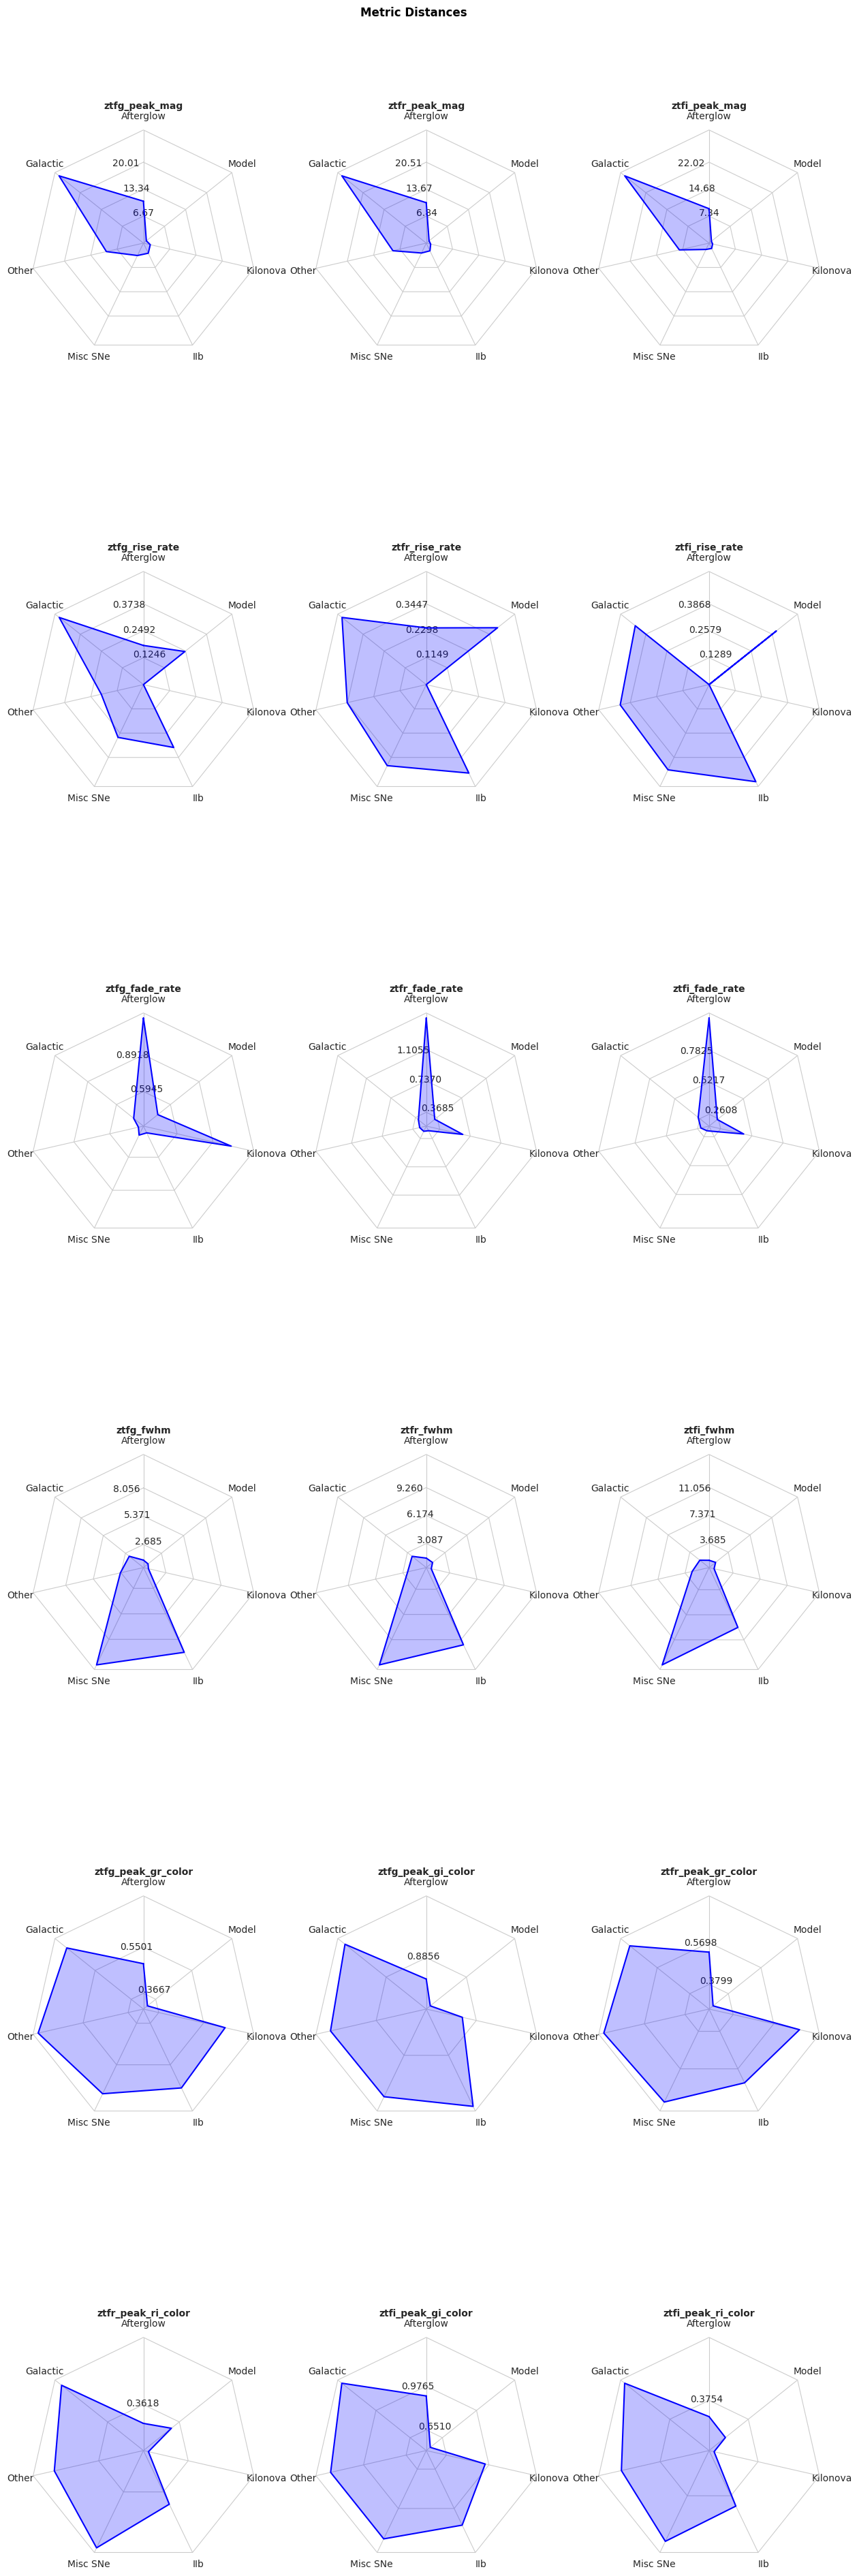

In [31]:
N = len(radar_data[0])

theta = radar_factory(N, frame='polygon')

#data = example_data()
spoke_labels = radar_data[0]
data = radar_data[1:]
print(np.shape(radar_data))

fig, axs = plt.subplots(figsize=(15, 7*int(np.shape(radar_data)[0]/3)), nrows=int(np.shape(radar_data)[0]/3), ncols=3,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.95, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate Axes
for ax, (title, case_data) in zip(axs.flat, data):
    case_data_max = np.max(case_data)
    ax.set_rgrids([case_data_max/4, case_data_max/2, case_data_max*3/4])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# # add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                             labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Metric Distances',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

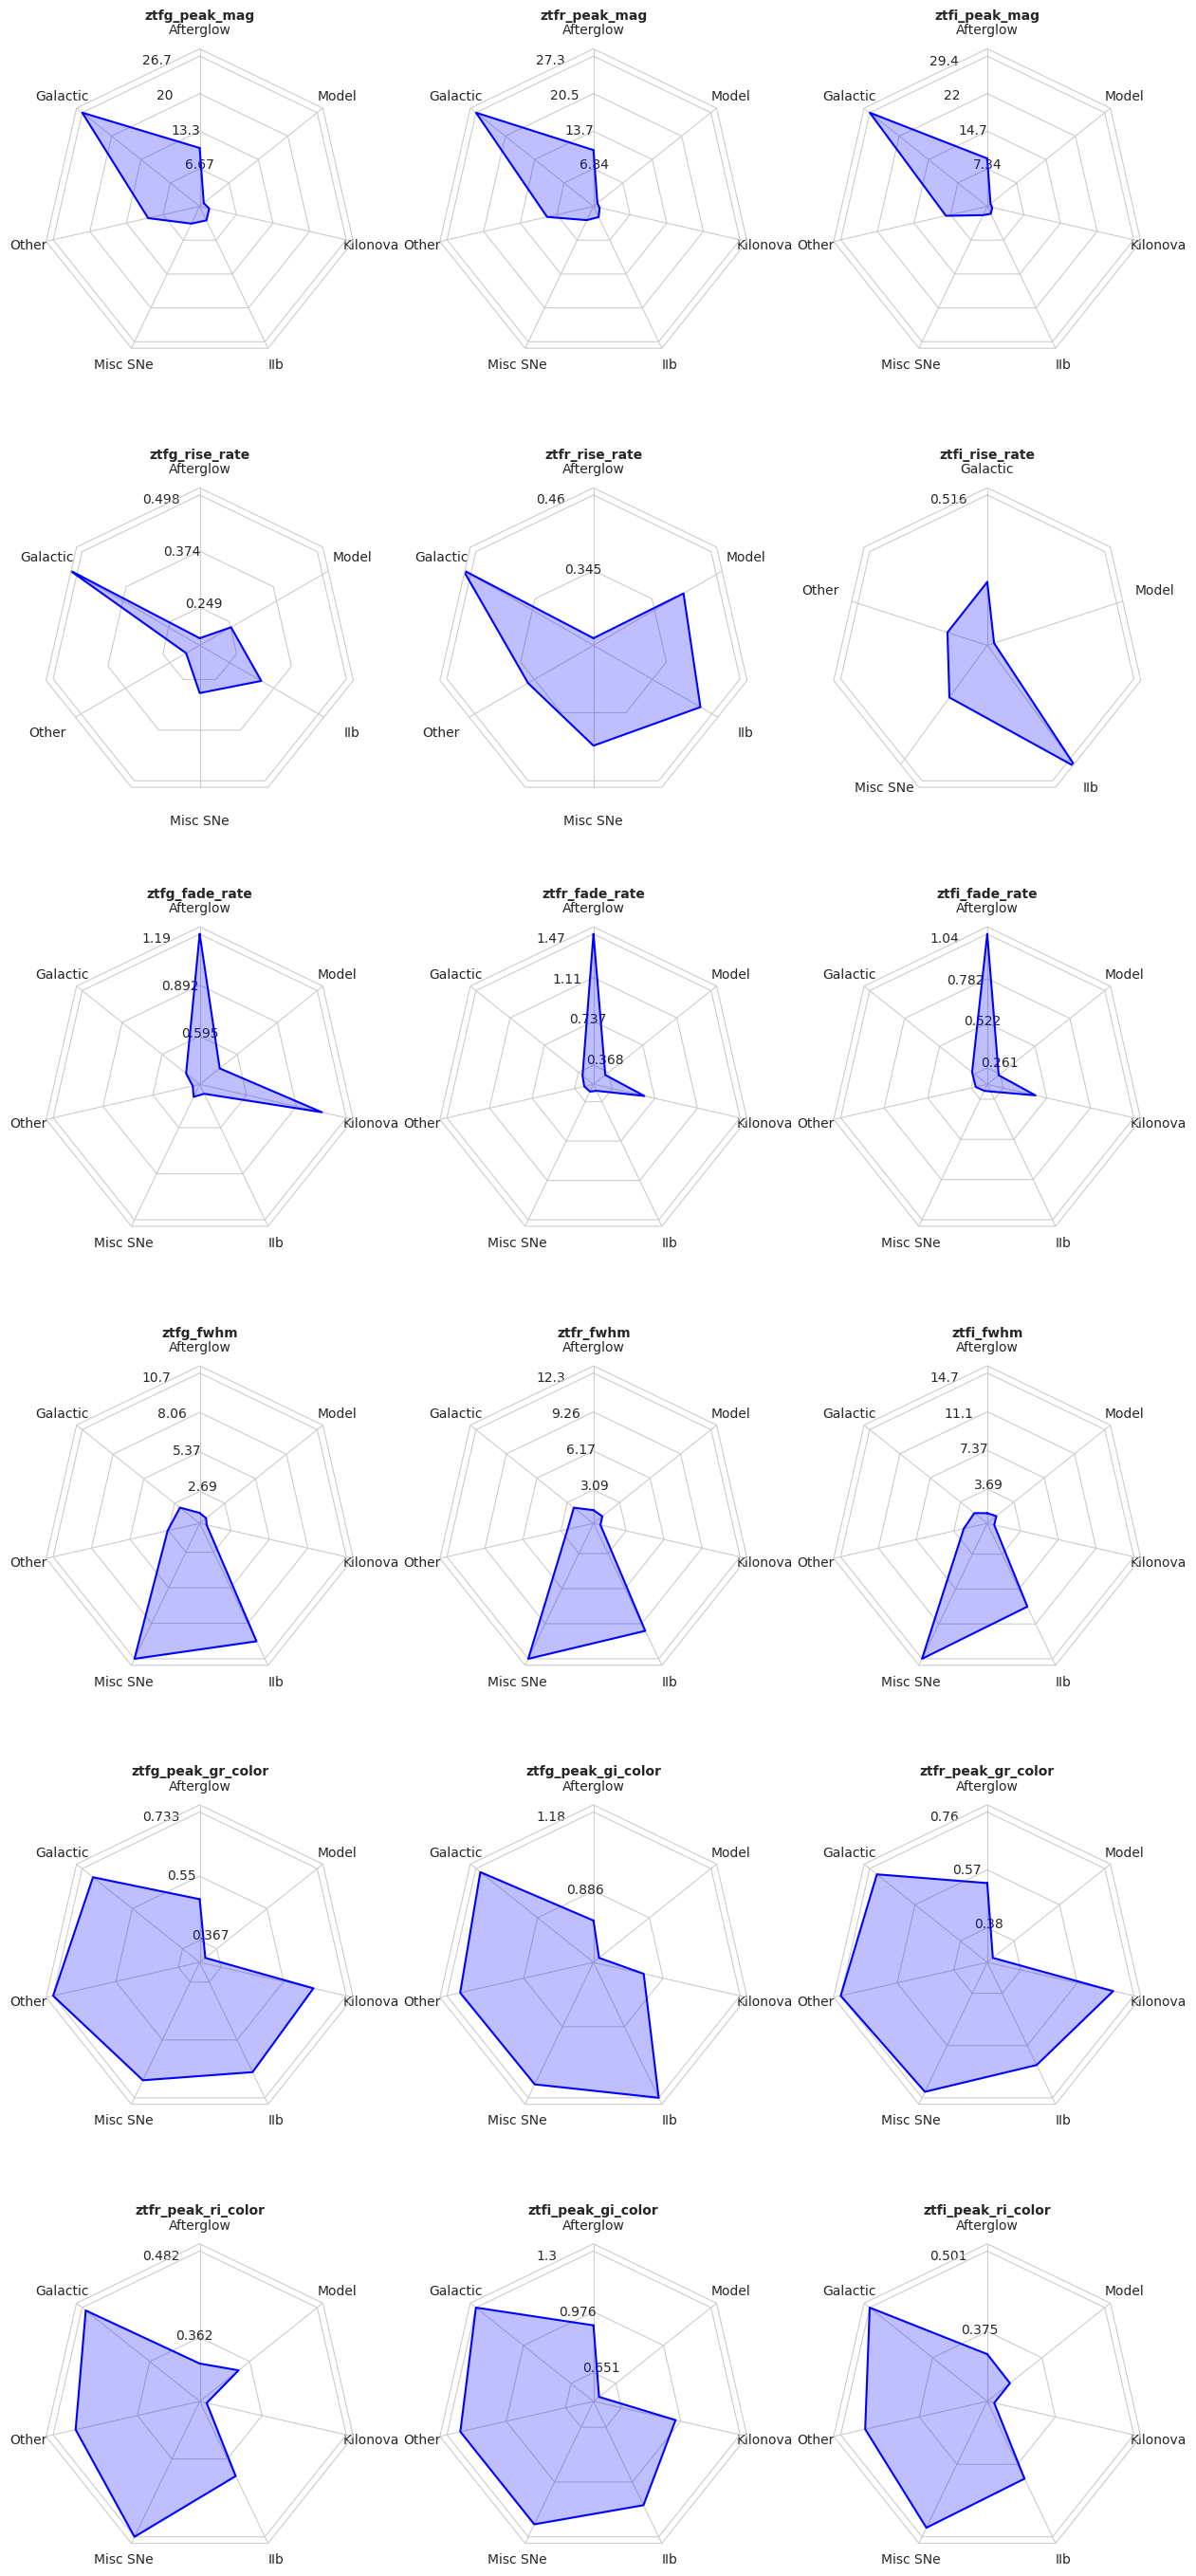

In [32]:
import numpy as np
import matplotlib.pyplot as plt


# Function to filter data and labels for a single subplot
def filter_data(case_data, spoke_labels):
    """Filters data and spoke labels based on non-zero values."""
    spoke_labels_filtered = [label for label, value in zip(spoke_labels, case_data[0]) if value != 0]
    case_data_filtered = [value for value in case_data[0] if value != 0]
    theta_filtered = np.linspace(0, 2 * np.pi, len(case_data_filtered), endpoint=False)
    return theta_filtered, case_data_filtered, spoke_labels_filtered

# Create the subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(radar_data[1:]) / 3)), ncols=3, 
                        figsize=(15, 5 * int(np.ceil(len(radar_data[1:]) / 3))), 
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.95, bottom=0.05)

# Get the spoke labels from the first row of radar_data
spoke_labels = radar_data[0]

# Plot the data on each subplot
for ax, (title, case_data) in zip(axs.flat, radar_data[1:]):

    # Filter data and labels for this subplot
    theta_filtered, case_data_filtered, spoke_labels_filtered = filter_data(case_data, spoke_labels)

    case_data_max = np.max(case_data_filtered)
    ax.set_rgrids([case_data_max/4, case_data_max/2, case_data_max*3/4,case_data_max])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    
    # Since you have only one color, you don't need the loop
    ax.plot(theta_filtered, case_data_filtered, color='b')
    ax.fill(theta_filtered, case_data_filtered, facecolor='b', alpha=0.25, label='_nolegend_')
    
    # Set the spoke labels and angles to match
    ax.set_thetagrids(np.degrees(theta_filtered), spoke_labels_filtered)
    ax.set_yticklabels([f"{i:.3g}" for i in ax.get_yticks()],zorder=np.inf)  # Hide radial axis labels

# Add title to the figure
# fig.text(0.5, 0.965, 'Metric Distances',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

# plt.tight_layout()
plt.show()

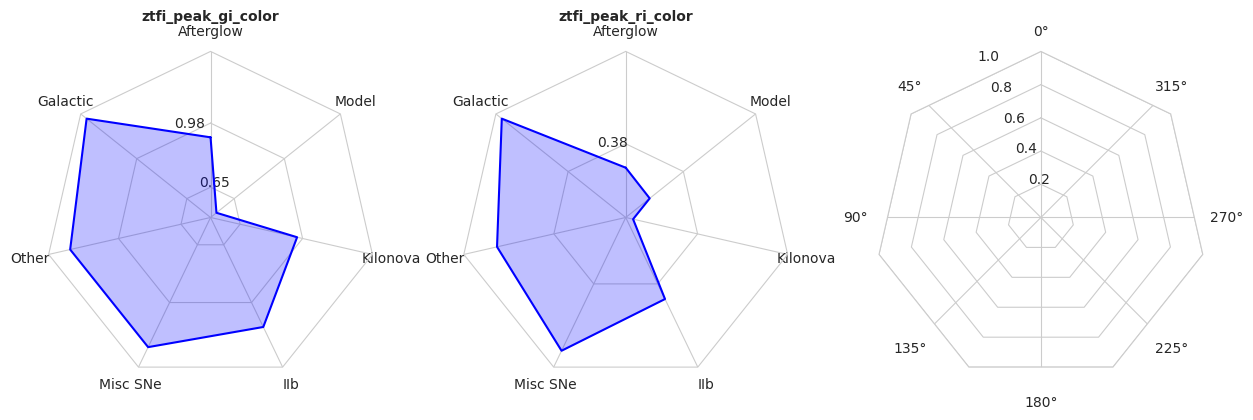

In [33]:
import numpy as np
import matplotlib.pyplot as plt

## just the first value and then the 4,5,6 values
sub_radar_data = radar_data[:1] + radar_data[17:19]

# Function to filter data and labels for a single subplot
def filter_data(case_data, spoke_labels):
    """Filters data and spoke labels based on non-zero values."""
    spoke_labels_filtered = [label for label, value in zip(spoke_labels, case_data[0]) if value != 0]
    case_data_filtered = [value for value in case_data[0] if value != 0]
    theta_filtered = np.linspace(0, 2 * np.pi, len(case_data_filtered), endpoint=False)
    return theta_filtered, case_data_filtered, spoke_labels_filtered

# Create the subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(sub_radar_data[1:]) / 3)), ncols=3, 
                        figsize=(15, 5 * int(np.ceil(len(sub_radar_data[1:]) / 3))), 
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.95, bottom=0.05)

# Get the spoke labels from the first row of sub_radar_data
spoke_labels = sub_radar_data[0]

# Plot the data on each subplot
for ax, (title, case_data) in zip(axs.flat, sub_radar_data[1:]):

    # Filter data and labels for this subplot
    theta_filtered, case_data_filtered, spoke_labels_filtered = filter_data(case_data, spoke_labels)

    case_data_max = np.max(case_data_filtered)
    ax.set_rgrids([case_data_max/4, case_data_max/2, case_data_max*3/4])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    
    # Since you have only one color, you don't need the loop
    ax.plot(theta_filtered, case_data_filtered, color='b')
    ax.fill(theta_filtered, case_data_filtered, facecolor='b', alpha=0.25, label='_nolegend_')
    
    # Set the spoke labels and angles to match
    ax.set_thetagrids(np.degrees(theta_filtered), spoke_labels_filtered)
    ax.set_yticklabels([f"{i:.2g}" for i in ax.get_yticks()])  # Hide radial axis labels

# plt.tight_layout()
plt.show()

In [34]:
model_risepeak_list = list(zip(df_2019['ztfg_rise_rate'], df_2019['ztfg_peak_mag']))
objects_risepeak_list = list(zip(df_rates['ztfg_rise_rate'], df_rates['ztfg_peak_mag']))
# print(objects_risepeak_list)
# print(df_risepeak['obj_id'])
distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}

In [35]:
for filt in ['ztfg', 'ztfr', 'ztfi']:
    model_risepeak_list = list(zip(df_2019[f'{filt}_rise_rate'], df_2019[f'{filt}_peak_mag']))
    objects_risepeak_list = list(zip(df_rates[f'{filt}_rise_rate'], df_rates[f'{filt}_peak_mag']))
    distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}
    df_rates[f'{filt}_risepeak_distance'] = distance_risepeak.values() 
    
    model_fadepeak_list = list(zip(df_2019[f'{filt}_fade_rate'], df_2019[f'{filt}_peak_mag']))
    objects_fadepeak_list = list(zip(df_rates[f'{filt}_fade_rate'], df_rates[f'{filt}_peak_mag']))
    distance_fadepeak = {obj: metric_distance(obj_data, model_fadepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_fadepeak_list)}
    df_rates[f'{filt}_fadepeak_distance'] = distance_fadepeak.values()

<Axes: xlabel='ztfg_fadepeak_distance', ylabel='Count'>

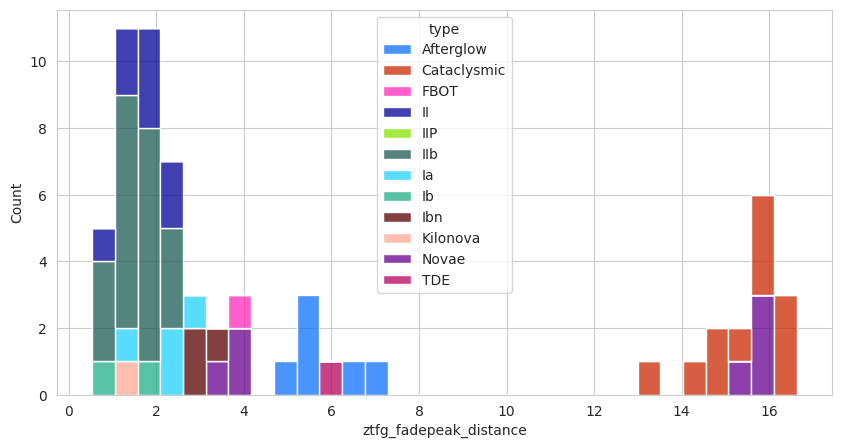

In [36]:
sns.set_palette('colorblind')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=df_rates, x='ztfg_fadepeak_distance', hue='type', palette=colors_dict, multiple='stack', ax=ax, bins=31)

((-0.01, 0.25), (-0.05, 35.0))

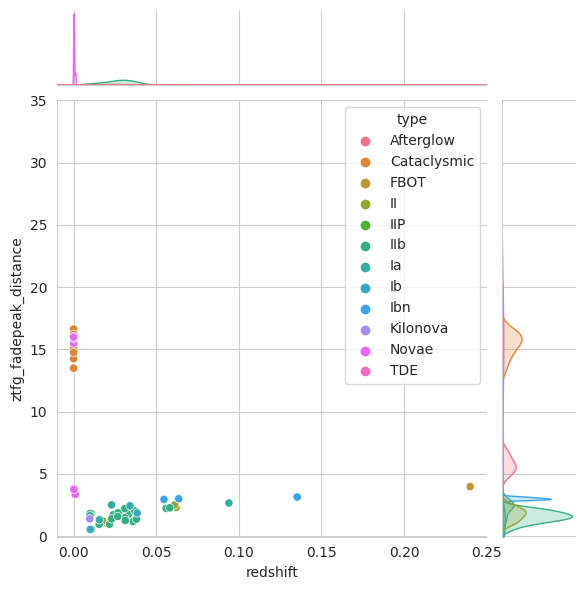

In [37]:
JG1 = sns.jointplot(data=df_rates, x='redshift', y='ztfg_fadepeak_distance', hue='type',markers='type')
JG1.ax_marg_x.set_xlim(-0.01,0.25), JG1.ax_marg_y.set_ylim(-0.05,35)
# JG1.ax_marg_x.set_xlim(-0.3,None), JG1.ax_marg_y.set_ylim(-1,None)

In [38]:
# filters = ['ztfg', 'ztfr', 'ztfi'] 
# y_column = 'redshift'
# x_columns = {
#     'ztfg': 'ztfg_risepeak_distance',
#     'ztfr': 'ztfr_risepeak_distance',
#     'ztfi': 'ztfi_risepeak_distance'
# }

# fig = plt.figure(figsize=(10, 15))
# gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

# handles, labels = [], []

# for i, filt in enumerate(filters):

#     x_column = x_columns[filt]

#     ax_scatter = fig.add_subplot(gs[i*2, 0])
#     scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter, palette=colors_dict)
#     ax_scatter.set_title(f'{filt}')
#     ax_scatter.set_ylabel('Redshift')
#     ax_scatter.set_xlabel(None)

#     if i == 0:
#         handles, labels = ax_scatter.get_legend_handles_labels()
#     ax_scatter.legend_.remove()
    
#     ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
#     #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
#     sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
#     ax_hist.set_xlabel('Avg. Distance to Model')
#     #ax_hist.set_ylabel('Count')

# fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")
# fig.suptitle('Rise vs Peak Metric Distance', y=0.91)
# plt.tight_layout(rect=[0, 0, 0.85, 1])
# plt.savefig(f'figures/rise_vs_peak_metric_distance{ext}', bbox_inches='tight') if savefigs else None
# plt.show()

In [39]:
# filters = ['ztfg', 'ztfr', 'ztfi'] 
# y_column = 'redshift'
# x_columns = {
#     'ztfg': 'ztfg_fadepeak_distance',
#     'ztfr': 'ztfr_fadepeak_distance',
#     'ztfi': 'ztfi_fadepeak_distance'
# }

# fig = plt.figure(figsize=(10, 15))
# gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

# handles, labels = [], []

# for i, filt in enumerate(filters):

#     x_column = x_columns[filt]

#     ax_scatter = fig.add_subplot(gs[i*2, 0])
#     scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter)
#     ax_scatter.set_title(f'{filt}')
#     ax_scatter.set_ylabel('Redshift')
#     ax_scatter.set_xlabel(None)

#     if i == 0:
#         handles, labels = ax_scatter.get_legend_handles_labels()
#     ax_scatter.legend_.remove()
    
#     ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
#     #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
#     sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
#     ax_hist.set_xlabel('Avg. Distance to Model')
#     #ax_hist.set_ylabel('Count')

# fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")

# plt.tight_layout(rect=[0, 0, 0.85, 1])
# fig.suptitle('Fade vs Peak Metric Distance', y=0.91)
# plt.savefig(f'figures/fade_vs_peak_metric_distance{ext}', bbox_inches='tight') if savefigs else None
# plt.show()